In [40]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import ast as ast
from typing import *
from task_2_helpers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from transformers import pipeline

# nltk utils 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')
# nltk.download('wordnet')


**STUDENT1_ID:** 17306259, Alexis \
**STUDENT2_ID:** 07817257, Achraf \
**STUDENT3_ID:** 18329797, Fabian \
**STUDENT4_ID:** 18807297, Ezgi \
**STUDENT5_ID:** 13822853, Kyril 

## 2.0 Data Preprocessing

We started our analysis by reading the business, reviews and users datasets. We select the businesses located in Philadelphia. To do so, we used the Postal Code column. According to out research, Philadelphia postal codes fall in the range of [19019, 19255].

In [41]:
### Data Read
df_business = pd.read_csv('data/ATML2024_businesses.csv', header=0)
print(f"Business data: {df_business.shape}, columns: {list(df_business.columns)}")

df_Train_reviews = pd.read_csv('data/ATML2024_reviews_train.csv', header=0)
print(f"Reviews data: {df_Train_reviews.shape}, columns: {list(df_Train_reviews.columns)}")

df_users = pd.read_csv('data/ATML2024_users.csv', header=0)
print(f"Users data: {df_users.shape}, columns: {list(df_users.columns)}")


Business data: (138210, 11), columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'attributes', 'categories', 'hours']
Reviews data: (1050000, 9), columns: ['id', 'user_id', 'business_id', 'rating', 'useful', 'funny', 'cool', 'text', 'date']
Users data: (747468, 19), columns: ['user_id', 'name', 'user_since', 'useful', 'funny', 'cool', 'premium_account', 'friends', 'fans', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer']


Following data cleaning methods applied to the business data columns:
- **postal_code:** converted to numeric and selected the values in [19019, 19255] for Philadelphia
- **attributes:** cast as dictionary; attributes that value:True are extracted and add to the list of attributes. We also extracted the nested attributes in the similar and add them into list in the form of main attirbute-nested attribute.
- **hours:** cast as dictionary; converted to list of list of working hours per day of the week. Each row has a list size 7, representing the work day and each index have a list of size 2 repsenting the working hour of the day ast [start h, end h]. If a business doens't operate a specific day we put [-1,-1] as working hour.
- **categories:** converted from comma seperated string to list of categories  

After cleaning and selection, we merge business data with ratings data. We only keep the columns that are of our interest for the future usage. Since we are only interested in the restaurant businesses in Philadelphia, we further trim our dataset to contain only the restaurant businesses. We do that by selecting rows those category list includes restaurants. After our many observations we concluded that such a selection criteria is enough to identify the vast majority of restaurant businesses in Philadelphia.

In [42]:
df_business_ph = select_preprocess_Phili_business(df_business)
print("Philadelphia businesses data", df_business_ph.shape)

df_data = pd.merge(df_business_ph[['business_id', 'postal_code_int', 'attributes_list', 'hours_list', 'categories_list', 'latitude', 'longitude']],
                   df_Train_reviews, left_on= 'business_id', right_on='business_id')

print("Philadelphia businesses with ratings data", df_data.shape)


# Select only restaurant businesses
df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]

print("Philadelphia restaurant businesses with ratings data", df_data_res.shape)

df_data_res.to_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet')
df_data_res.head(5)

Philadelphia businesses data (19707, 15)
Philadelphia businesses with ratings data (176549, 15)
Philadelphia restaurant businesses with ratings data (123414, 15)


,business_id,postal_code_int,attributes_list,hours_list,categories_list,latitude,longitude,id,user_id,rating,useful,funny,cool,text,date
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,100621,Ax5a6F5AaOoPi-1MwOeuaM,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,174063,QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,234948,gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,285755,wKRfxlkzQXfEsHSDYhPVVq,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,330446,QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08


## Data Read

In [63]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)

(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


# Task 2.1 
Our objective is to extract insights into what consumers tend to like. To discover this, our approach is based on the following steps. First, we will prepare the data to obtain a clean dataset usable for the rest of the analysis. Secondly, we will apply a score-based analysis on the "rating" variable, before moving on to a sentiment-based analysis. Finally, we'll compare the two analyses to identify similarities and extract insights into preferences.

## Task 2.1.1 Preprocessing

#### 1. General dataset preparation

The goal of this step is to create a dataset that can be used for the following parts. We want to obtain a high-quality reference dataframe for our analysis. We therefore begin by joining the various useful datasets. We reduce it to focus on Philadelphia and to keep only the reviews associated to restaurants. The latter was made possible thanks to the use of the "categories_list" variable, which we had to process as well to identify the category topics associated to restaurants.  We noticed that some categories were very rarely present in the total reviews, and therefore did not fit in with the general representativeness of consumers.

In [64]:
# Removing categories with less than 5% presence in the total data
                                       
data_ratings =  df_data_res[['categories_list', 'rating']]
data_cat_rating_single = data_ratings.explode('categories_list')

data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_ratings)

data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}).sort_values(by='rating_freq_ratio', ascending=False)

# Keeping only frequent categories
data_cat_rare = set(data_cat[(data_cat['rating_freq_ratio'] <= 0.05) ]["categories"])
data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]

data_cat.sort_values(by='rating_freq_ratio', ascending=False).head(5)

,categories,frequency,mean_rating,rating_freq_ratio
176548,restaurants,123410,3.781598,0.999968
176522,food,37842,3.888642,0.306626
176268,nightlife,36472,3.714987,0.295526
176131,bars,35225,3.716082,0.285421
176131,american (new),26829,3.779791,0.217390


In [65]:
# Removing attributes with less than 5% presence in the total data
data_ratings =  df_data_res[['attributes_list', 'rating']]
data_attr_rating_single = data_ratings.explode('attributes_list')

data_attr_rating_single['mean_rating'] = data_attr_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_attr_rating_single['frequency'] = data_attr_rating_single['attributes_list'].map(data_attr_rating_single['attributes_list'].value_counts())
data_attr_rating_single['rating_freq_ratio'] = data_attr_rating_single['frequency']/len(data_ratings)

data_attr = data_attr_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}).sort_values(by='rating_freq_ratio', ascending=False)
 

# Keeping only frequent attributes using the lower quartile as threshold.
data_attr_rare = set(data_attr[(data_attr['rating_freq_ratio'] <= 0.05) ]["attributes"])
data_attr = data_attr[(data_attr['rating_freq_ratio'] > 0.05) ]
data_attr.sort_values(by='mean_rating', ascending=False).head(5)


,attributes,frequency,mean_rating,rating_freq_ratio
175989,ByAppointmentOnly,20975.0,4.029273,0.169956
176422,BYOB,18047.0,3.962653,0.146231
176363,GoodForMeal-brunch,14885.0,3.953846,0.120610
176420,DogsAllowed,58831.0,3.952797,0.476696
176420,Ambience-trendy,17443.0,3.941352,0.141337


We remove those categories and attributes which present less than 5% of the restaurants from the analysis. We believe these are outlier features and removing them improves the quality of the analysis.
 This step is replicated on "attributes_list" as follows.

#### 2. Preparing NLP models
After this filtering, we then prepare the dataset for use by the NLP models. We will use 2 NLP models.  

Classification is used to associate a larger group with categorie and attribute elements.  We decided to restrict ourselves to classification by using a pre-trained modehl given its quality. Another solution would have been to use the properties of the K-Means clustering algorithm to define clusters based on the embeddings of categories and attributes respectively. We decided, however, to leave this interesting technique to be more concise in our response to the current task. More specifically, we will use "facebook/bart-large-mnli" (407M params) as it is known to be a "relevant", good and common model (seen during the seminar) for assessing whether a sequence belongs to a given class. Thus, one reason explaining why we relied on these two models is the size of the data used to train then and the quality of the data used.

Sentiment analysis will be useful for creating an alternative score to ratings and evaluating what reviews are saying.It will be carried out using "distilbert-base-uncased-finetuned-sst-2-english" (with 67M parameters and an accuracy of 91% on the validation set of an evaluation benchmark according to HuggingFace) as this is a lightweight model with good accuracy on English texts. Additional explanation will be given in section 2.


In [66]:
# Load NLP models
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

We encounter a challenge for perfomming sentiment-analysis processing. It is linked to a token limit that was not processable by a model. The models used were limited to 128 tokens. We overcame this problem in 3 steps. Firstly, by separating the reviews "text" into different columns per 125 tokens, each column was analyzed separately. Then, we used the "mode" to elect a predominant general sentiment based on the columns.

In [67]:
#### ATTENTION ####
# Please do not run this code unless being ready to block the notebook for the next 4h

#df_1, df_2, df_3 = split_tokens(df_data_res)

# To do: Move to Helper
def sentiment(text):
    try:
        output = sent_pipe(text)[0]["label"]
    except:
        output = None 
    return output

# Assign sentiments based on reviews 
#df_1["sentiment"] = df_1["text"].apply(sentiment)
#df_2["sentiment_1"] = df_2["token_1"].apply(sentiment)
#df_2["sentiment_2"] = df_2["token_2"].apply(sentiment)
#df_3["sentiment_1"] = df_3["token_1"].apply(sentiment)
#df_3["sentiment_2"] = df_3["token_2"].apply(sentiment)
#df_3["sentiment_3"] = df_3["token_3"].apply(sentiment)

# Store once here for safety (can be removed)
#df_data_full_1 = pd.concat([df_1, df_2, df_3], ignore_index=True)

# Extract the final sentiment (voted)
#df_2["sentiment"] = df_2[["sentiment_1", "sentiment_2"]].mode(axis=1)[0]
#df_3["sentiment"] = df_3[["sentiment_1", "sentiment_2","sentiment_3"]].mode(axis=1)[0]

# Drop columns
#df_2 = df_2.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2"])
#df_3 = df_3.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2","token_3", "sentiment_3"])

# Unify the datasets
#df_data = pd.concat([df_1, df_2, df_3], ignore_index=True)

#To be removed for final run (remove 3 lines) and uncomment the lines before
#df_data = pd.read_csv("data/df_data_full.csv", header=0)
#df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
#df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

#df_data.head(10)

In [9]:
# df_data = pd.read_csv("data/df_data_final.csv", header=0)
df_data = pd.read_parquet('data/df_data_final.parquet', engine='pyarrow')
df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

## 2.1.2 Analysis
Now let's take a look at the general preferences of consumers on this market. Our idea is to consider preferences firstly from a quantitative and qualitative point of view, and then from a sentimental one. The quantitative and qualitative aspects are more logical and easier to interpret (many of us are used to ratings), rather the a sentimental analysis. The reason for using a sentimental analysis is our ability to rationalize it. Indeed ,we condense a lot of information expressed through complex reviews into a binary score 0 = negative and 1 = positive. Ideally, both methods should be combined for interpretation.

### 1. Analysis based on logical metrics (ratings and distribution)
Our logical analysis begins with a look at the frequencies of categories associated with reviews. The more frequent a category, the more representative it is of the general opinion.

In [68]:
# All categories in a set
all_categories = set(np.concatenate(df_data_res.categories_list.values).ravel())

# Replace list by unique (individualize /create new rows) 
categories_individ_df = df_data_res.explode("categories_list")
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "restaurants"]
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "food"]

# Remove reviews with rare categories
categories_individ_df = categories_individ_df[~categories_individ_df['categories_list'].isin(data_cat_rare)]


# Define the groups
group_names = ["ambiance", "establishment","cuisine type" ]

# Initialize empty dictionary used to map group labels per category item
CategoryLabel = {}

# Assign a group to categories
for category in all_categories:
    output = classifier(category, group_names)
    CategoryLabel[category] = output["labels"][0]

# Mapping the group to the categories
categories_individ_df["group_categorie"] = categories_individ_df["categories_list"].map(CategoryLabel)

We use the classification model to assign each category a broader group name. The task requires us to analyze by food, services, rentals and so forth. For this reason, we will base our analysis on the "categories" and "attributes" variables, as we note that food items are concentrated in the category variable, while services are concentrated in the attribute variable. We have also added groups such as "ambience" and "establishment", which seem to be present in the data. Variable "postal code" can be used to provide insights about "location".


### Focus on categories

#### Approach 1 - Wide

In [11]:
# See the distribution of ratings
print(categories_individ_df["rating"].describe())
categories_individ_df.head()

count    319115.000000
mean          3.786356
std           1.314632
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64


,business_id,postal_code_int,attributes_list,hours_list,categories_list,latitude,longitude,id,user_id,rating,useful,funny,cool,text,date,group_categorie
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,100621,Ax5a6F5AaOoPi-1MwOeuaM,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03,cuisine type
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,174063,QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36,cuisine type
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,234948,gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14,cuisine type
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,285755,wKRfxlkzQXfEsHSDYhPVVq,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09,cuisine type
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,330446,QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08,cuisine type


Here we look at the 20 most frequent (unclassified) categories. We can see in the barplot that approximately 10 of them are very common before observing a change in popularity that tends to homogenizes. In term of food sandwiches, italian, pizza and chinese and seafood are particularly interesting. Restaurant associated to nightlife and bars are also popular.

/tmp/ipykernel_69510/2054356250.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


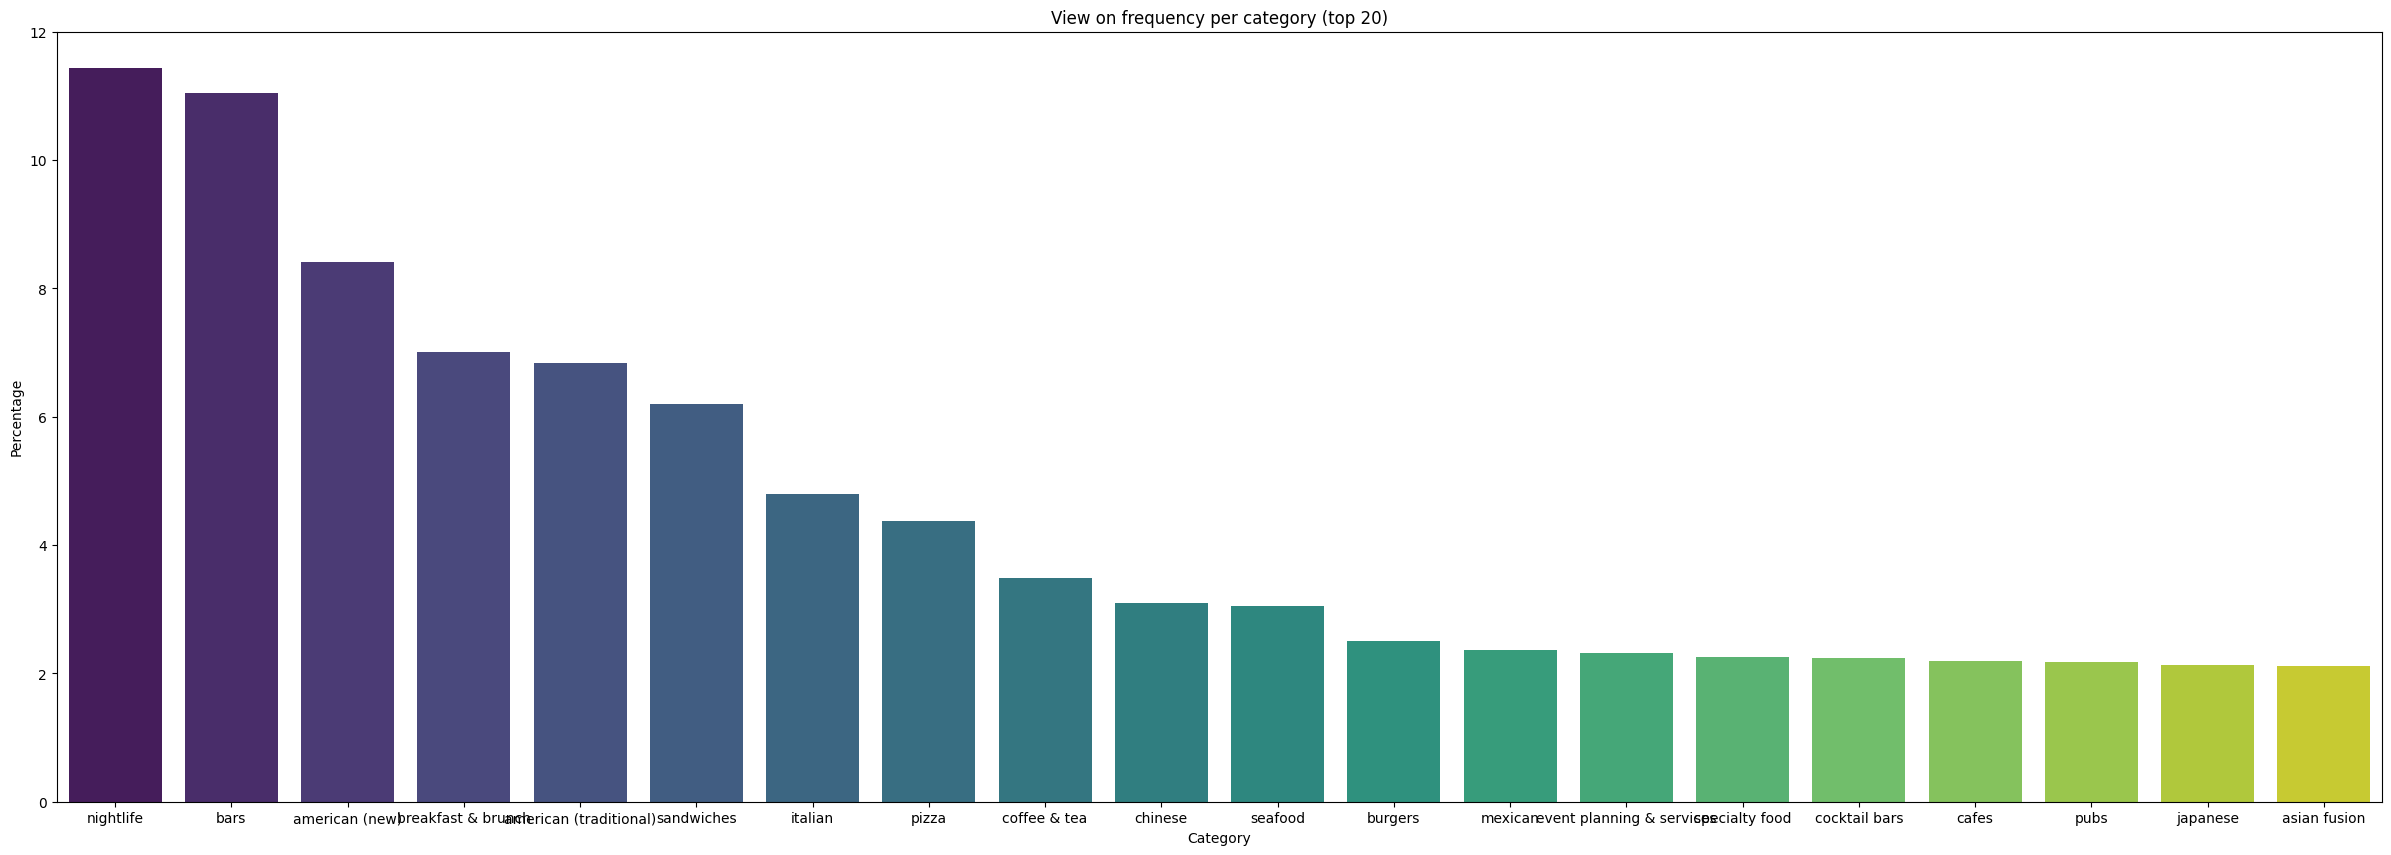

In [12]:
############################################################
# Percentage per category
category_counts = categories_individ_df["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View on frequency per category (top 20)")
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

Let's look now at ratings. We average them to see the top scores. Nothing insightfull seems to appear as the scores are rather homogeneous. We note however a preferrence for specialty food and different types of cuisine (asian, italian, mexican). For beverage it seems that cafes and restaurant associated to beer are liked.

/tmp/ipykernel_69510/1391953184.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


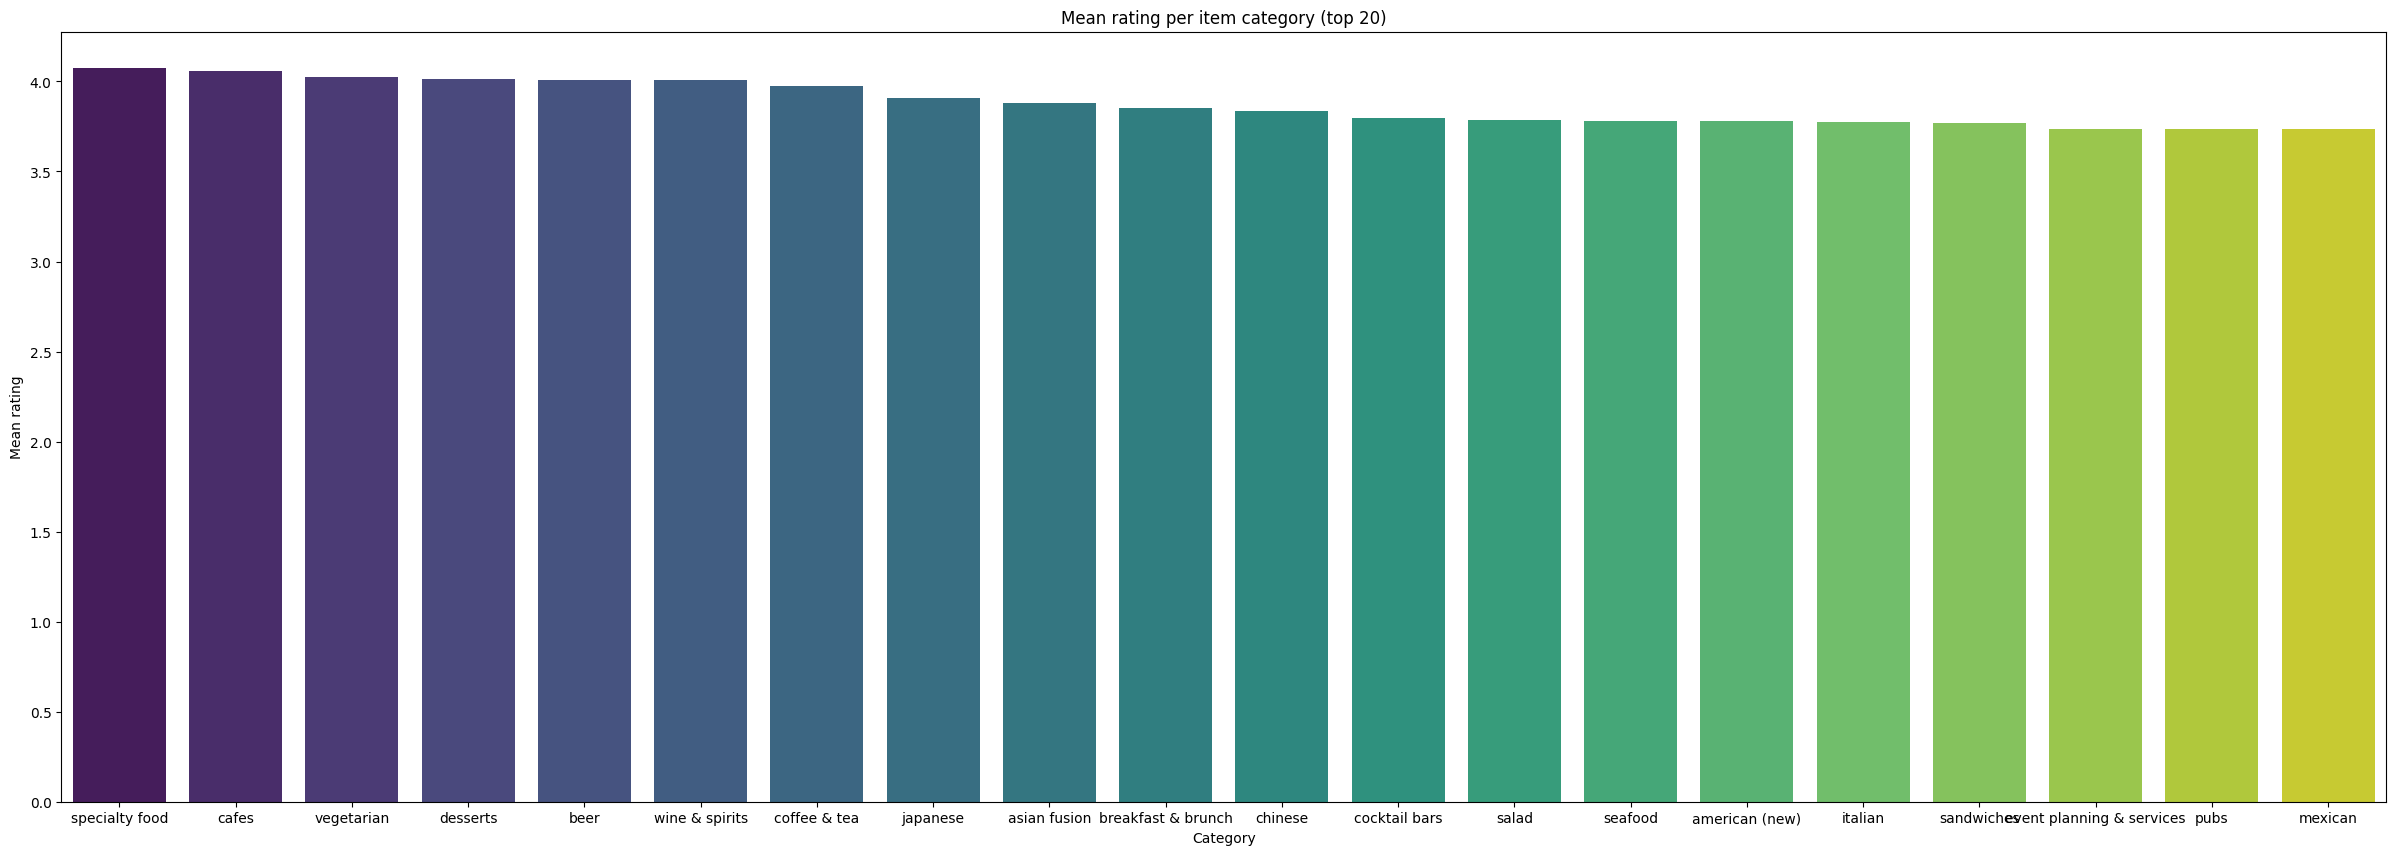

In [13]:
# Averaging the ratings per category

# Plot
mean_ratings = categories_individ_df.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per item category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean rating")
plt.show()

We change the approach slightly and apply a score comparison by diving into the groups in order to compare similar categories and potentially avoid the general homogenization effect. We note that this brings no significant change. As a result, we will have to change our approach and increase compelxity by applying some filters for example.

In [14]:
# Mean rating per category
mean_ratings["group_category"] = mean_ratings["categories_list"].map(CategoryLabel)
mean_ratings = mean_ratings.groupby(["group_category", "categories_list"])["rating"].mean().reset_index()
mean_ratings[mean_ratings["rating"] >= 4].sort_values(by=["group_category","rating", ], ascending=[False, False]).head(15)

,group_category,categories_list,rating
21,cuisine type,specialty food,4.072430
9,cuisine type,cafes,4.055706
22,cuisine type,vegetarian,4.024505
12,cuisine type,desserts,4.011555
6,cuisine type,beer,4.008834
3,ambiance,wine & spirits,4.008834


/tmp/ipykernel_69510/1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


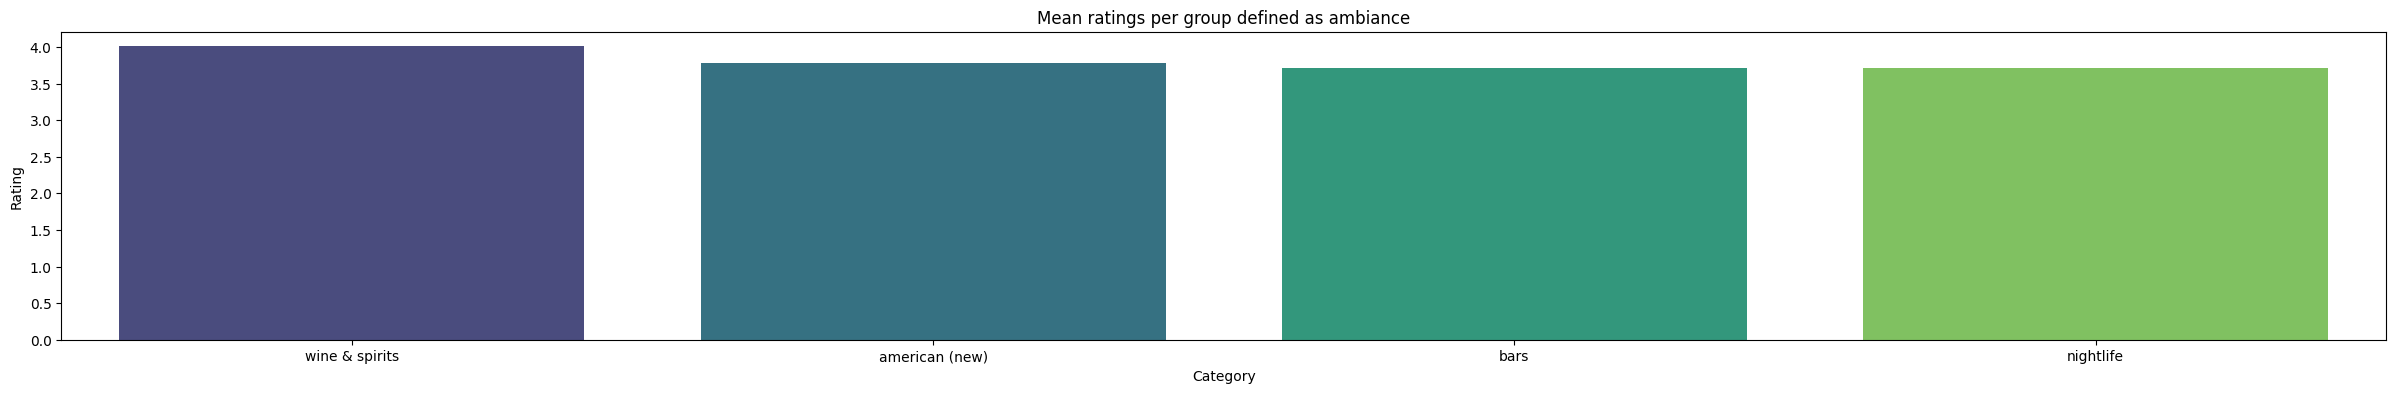

/tmp/ipykernel_69510/1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


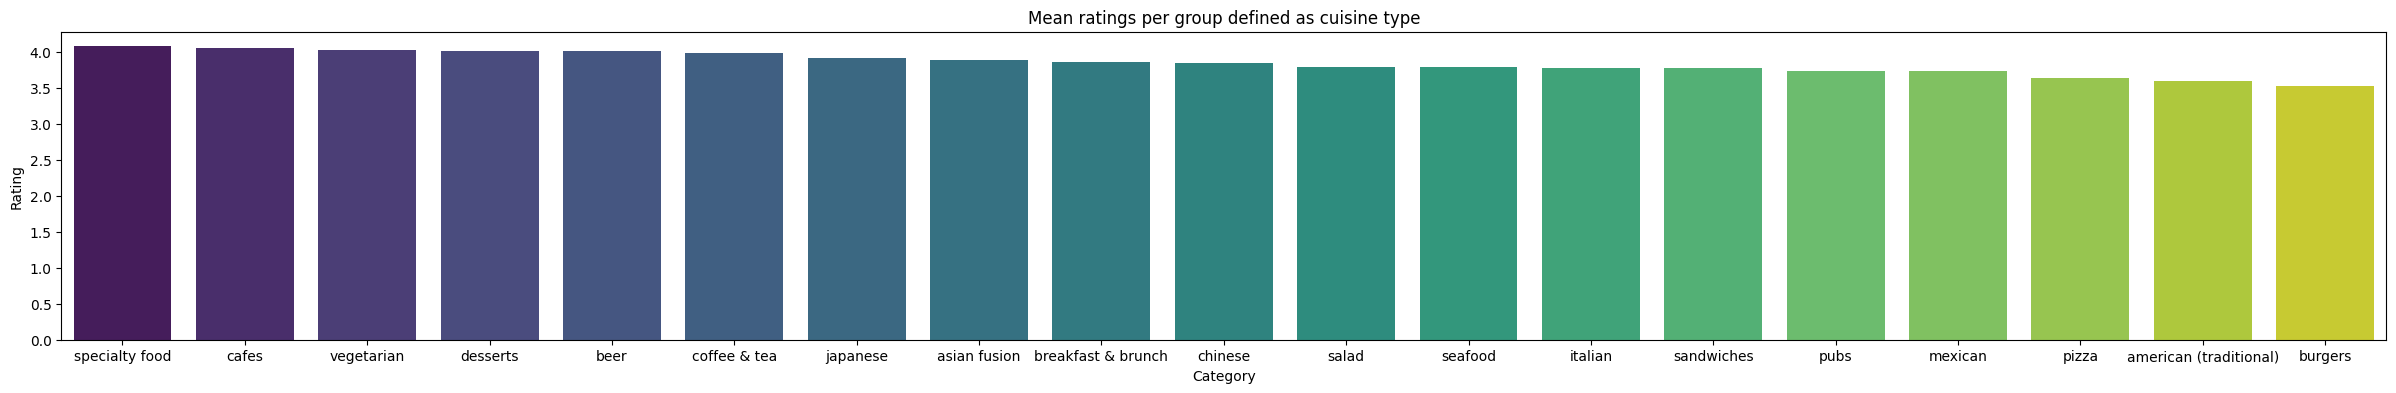

/tmp/ipykernel_69510/1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


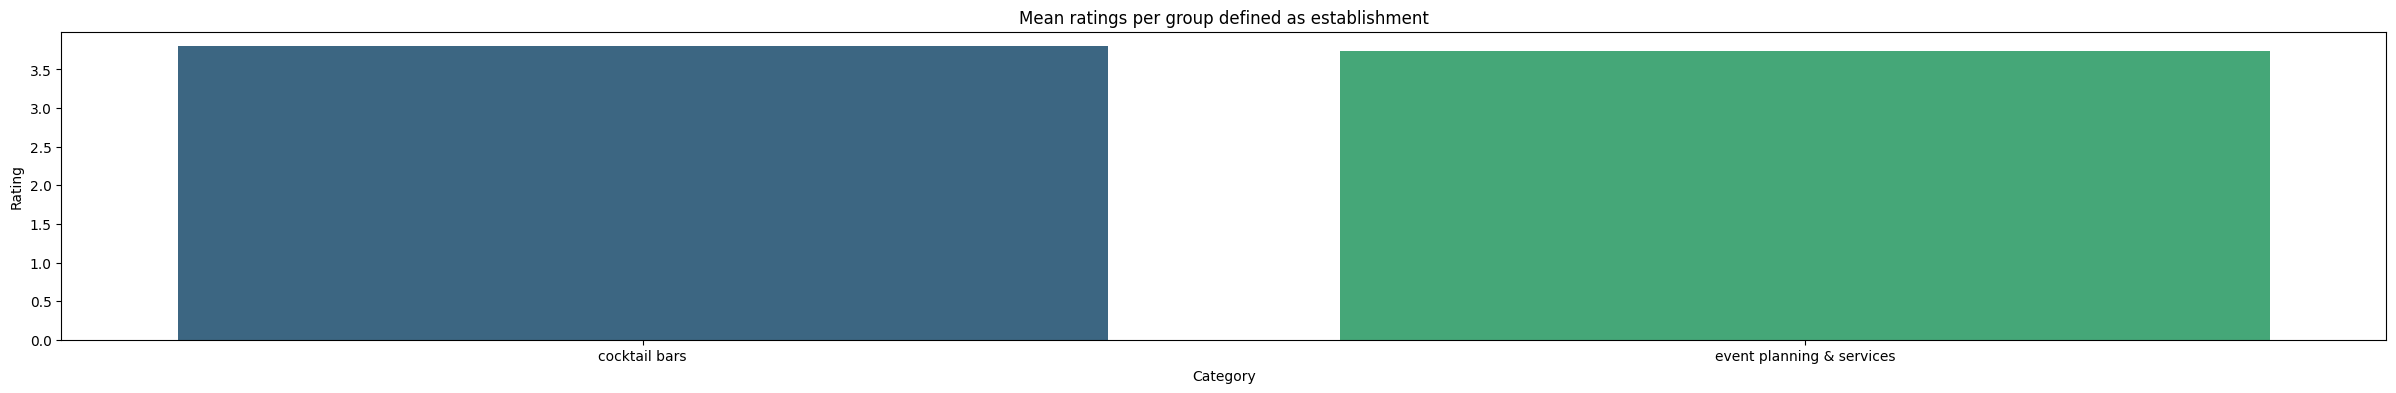

In [15]:
# Bar plots per group
for group in mean_ratings["group_category"].unique():
    df_ft = mean_ratings[mean_ratings["group_category"] == group]
    df_ft[["categories_list", "rating"]]
    df_ft = df_ft.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Mean ratings per group defined as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Rating")
    plt.show()

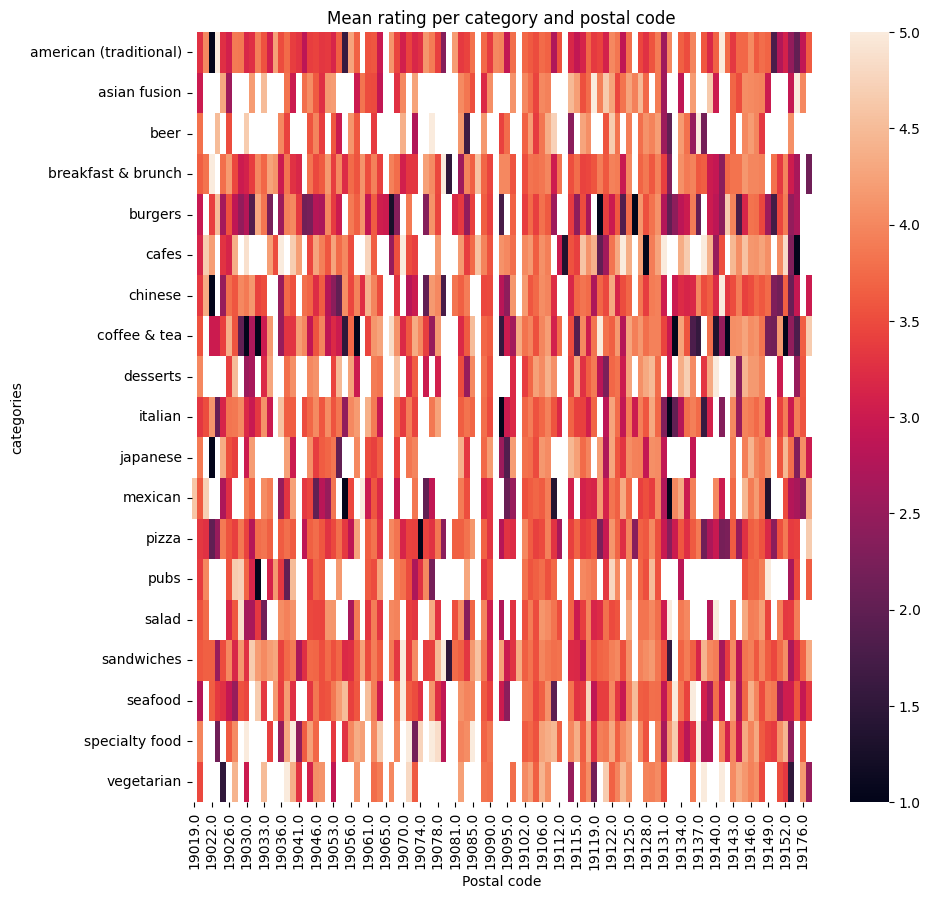

In [16]:
# Heat map per postal code
cuisine_df = categories_individ_df[categories_individ_df["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code_int"])["rating"].mean().reset_index().sort_values(by='postal_code_int')
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code_int", values="rating"))
plt.title("Mean rating per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

Before changing our approach, let's look at the average scores by zip code.This is a very interesting first piece of information. We can see that some postcodes lack categories and are therefore potentially ignored by consumers, while others are associated with almost all types of restaurant.

#### Approach 2 - keeping reviews judged useful at least 5 times

We can apply a filtering on the reviews to keep only the ones that have been judged "useful" and see how this new constraint affect the rankings. Doing it keep reviews rather important to the public opinion. We need to keep the threshold low to keep a lot of reviews and getting a representative view without excluding business with few reviews, but also high enough to perform a qualitative distinguishment with respect to the previous outputs. Given the large size of our data set and the general homogenization of results, we chose therefore to exclude reviews having not been judged useful or have been judged usful less than 5 times (after having noticed less significant improvement with inferior values). We avoid going to more than 5 times to consider enough reviews...

The next barplot shows that food such as sandwiches, italian cuisine, pizza, breakfast and brunch type of restaurants are getting a lot of reviews.

/tmp/ipykernel_69510/1619558882.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


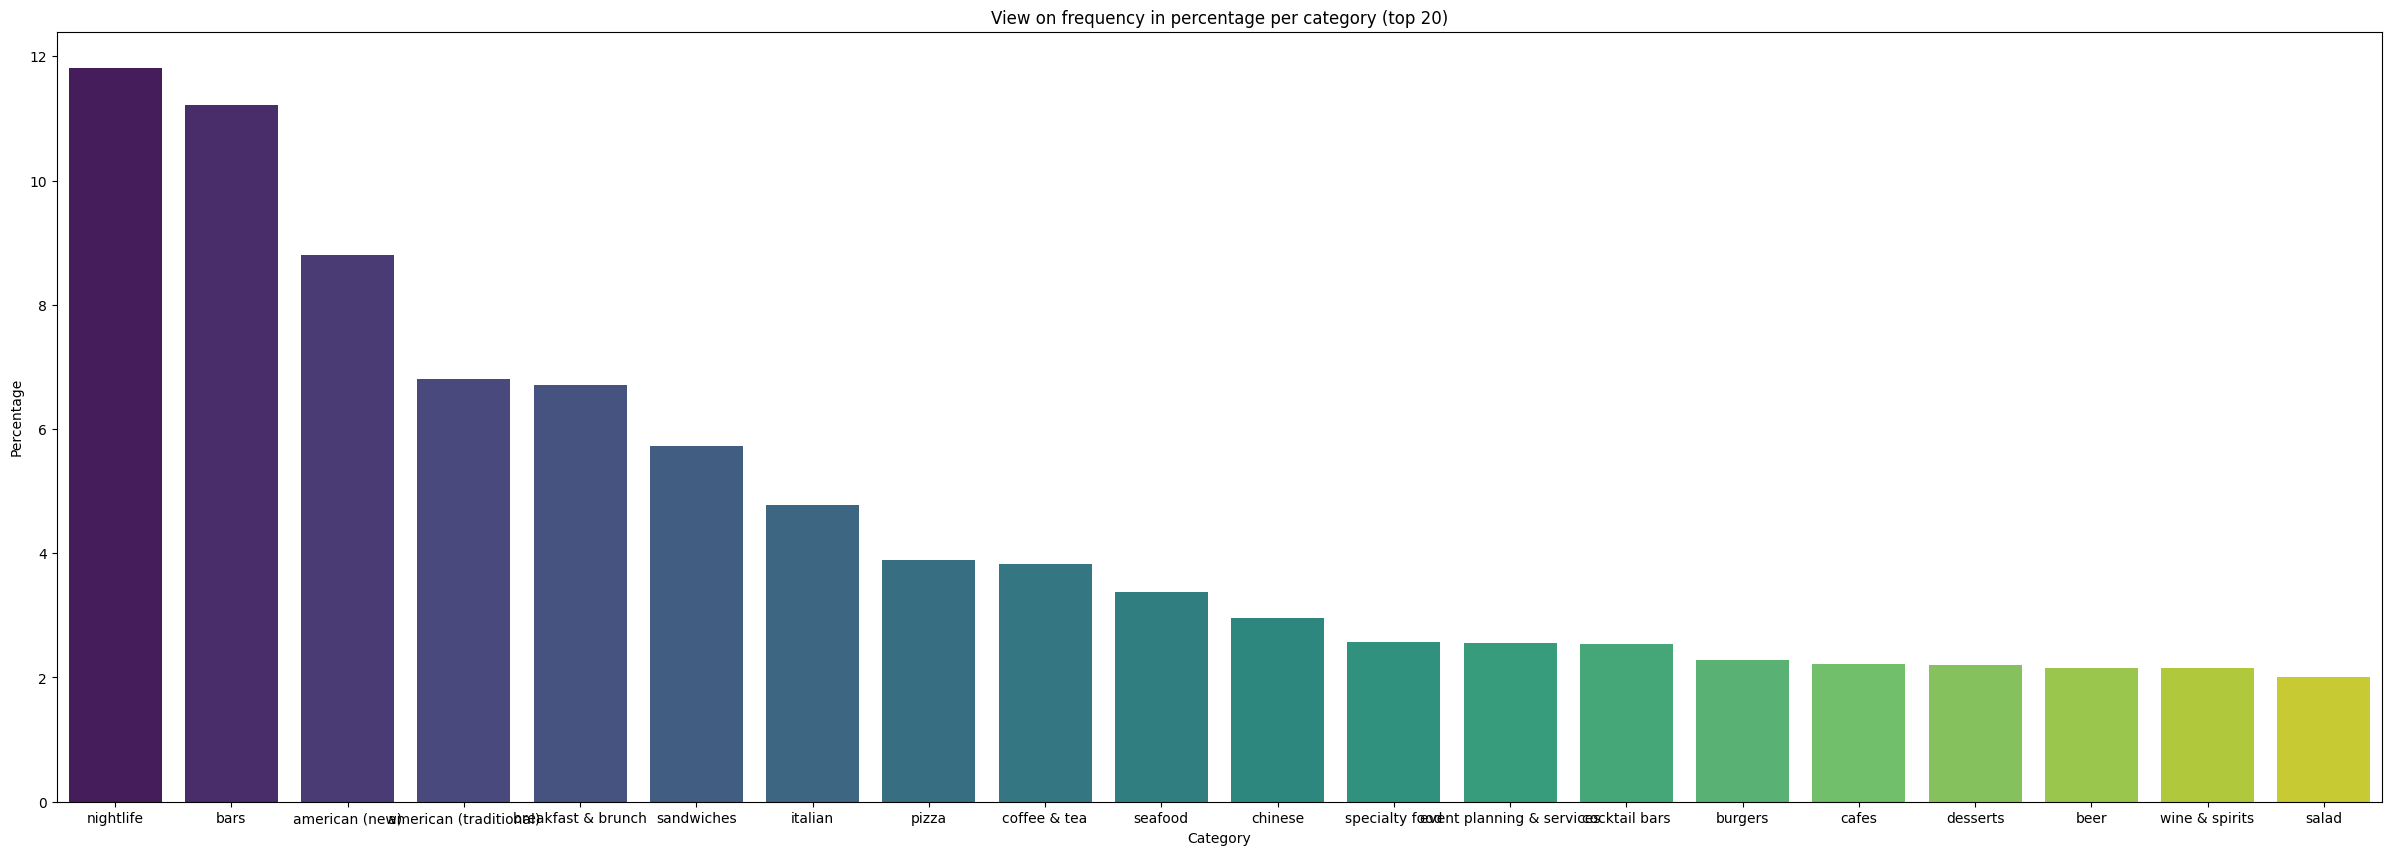

In [17]:
# Keep score in useful >= 3
df_data_utility = categories_individ_df[categories_individ_df["useful"] >= 5]

# Percentage
category_counts = df_data_utility["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 10))
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.title("View on frequency in percentage per category (top 20)")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

/tmp/ipykernel_69510/2424153314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


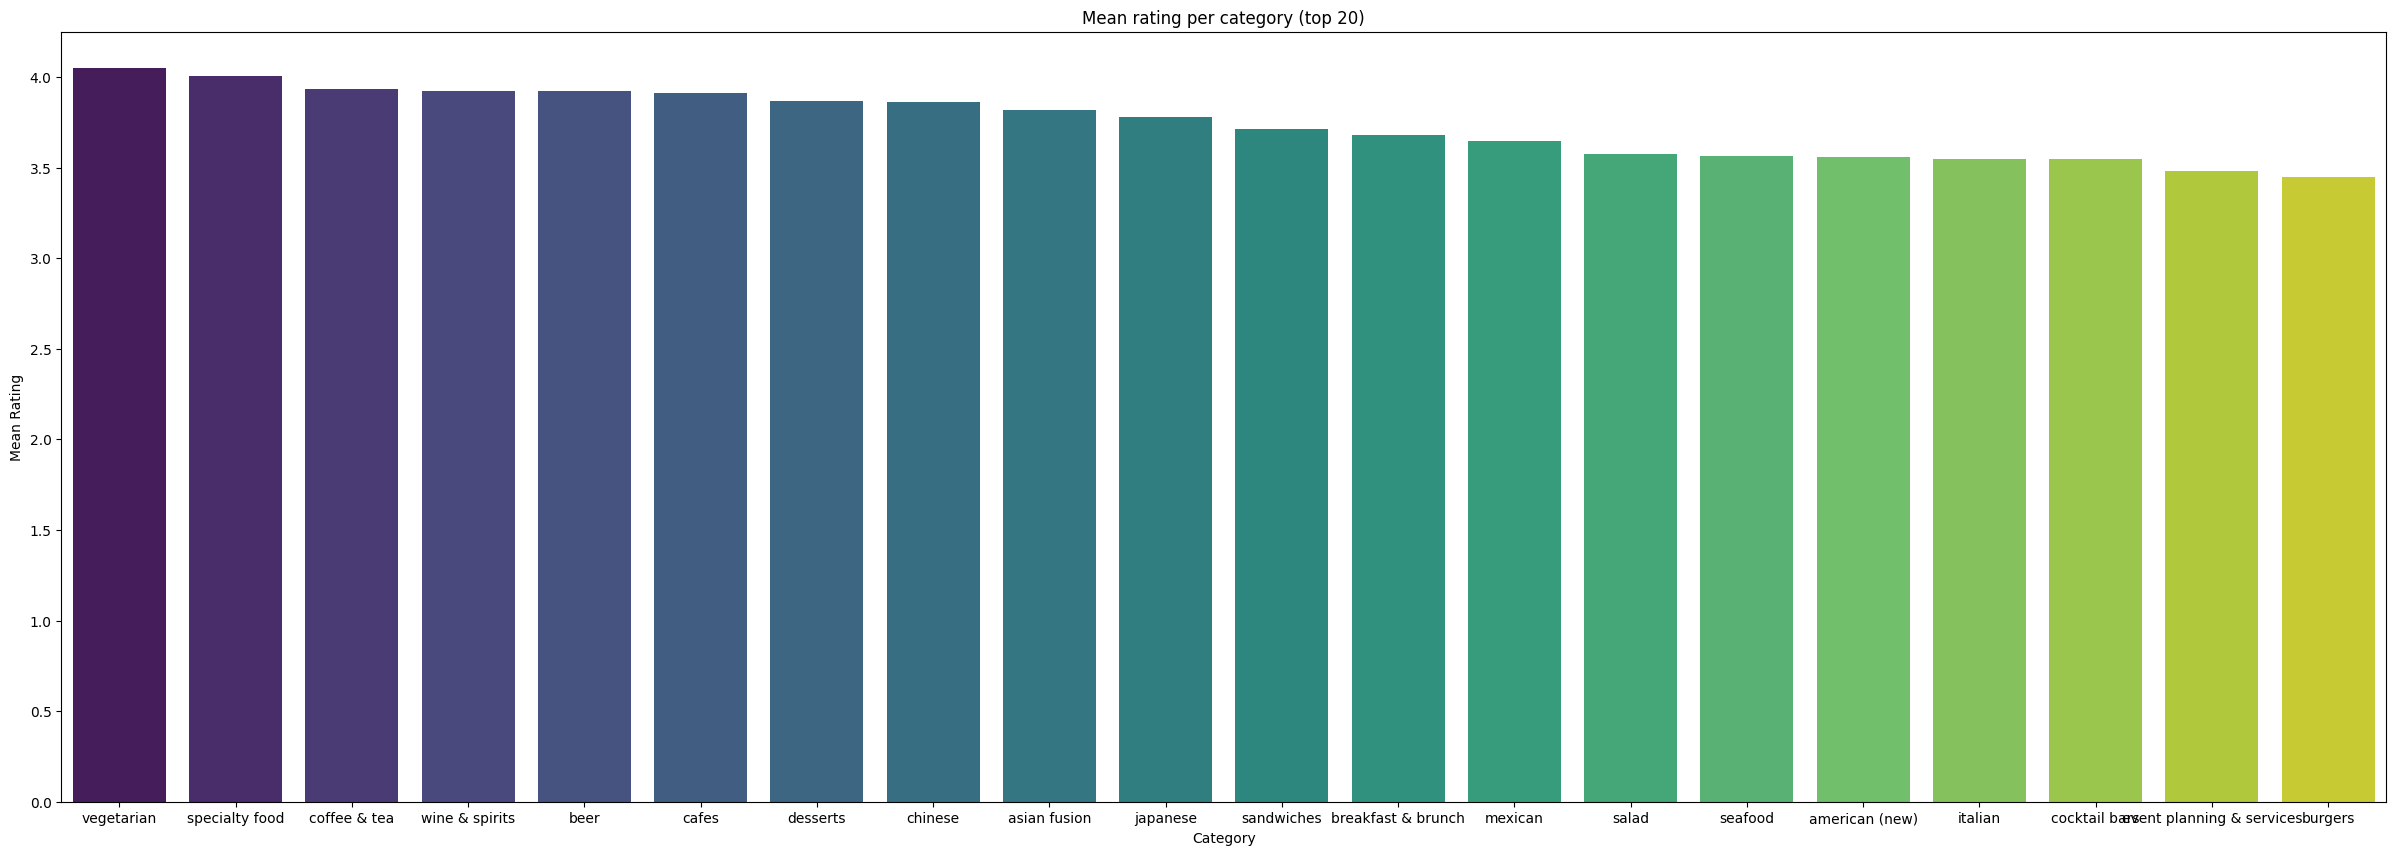

In [18]:
# Plot
mean_ratings = df_data_utility.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean Rating")
plt.show()

When we compare the two heatmaps, we can see some preferences among reviews for certain type of food such as Chicken wings, meditarenean or indian food. This approach show that these types of food give frequent and better reviews in general. Also, we see that some postcodes are no longer deserved, and we see better a bit btter which categories continue to be served. From the heatmaps we see now for example that reviews concentrates on postal codes such as 19103, 1907, 19146 or 19147... The offer and the demand seems to concentrate there. 

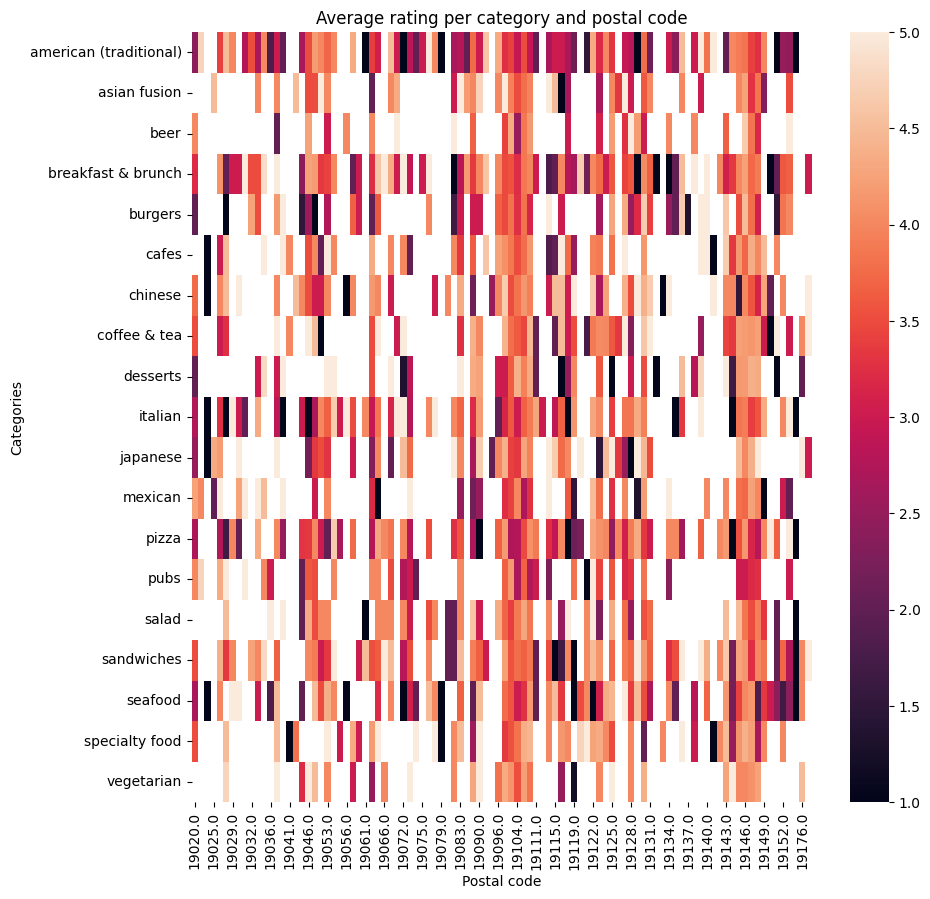

In [19]:
# Heat map per postal code
cuisine_df = df_data_utility[df_data_utility["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code_int"])["rating"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code_int", values="rating"))
plt.title("Average rating per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("Categories")
plt.show()

#### Focus on attributes

#### Approach 1 - Wide

We replicate the same steps as seen for categories, but this time with attributes.

In [49]:
# Reinitializing the dataset
# df_data = pd.read_csv("data/df_data_final.csv", header=0)
df_data = pd.read_parquet('data/df_data_final.parquet', engine='pyarrow')
# df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
# df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

# Split the dataset per attribute and remove observations with rare attributes
# df_data = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')

attribute_individ_df = df_data.explode("attributes_list")
attribute_individ_df = attribute_individ_df[~attribute_individ_df["attributes_list"].isin(data_attr_rare)]

# Put attributes in a set
all_attributes = set(np.concatenate(df_data.attributes_list.values).ravel())

In [52]:
# Group attributes  
group_names = ["facilities","food", "service", "atmosphere"]
Attribute_groups = {}

# Classify the attributes according to the groups
for category in all_attributes:
    output = classifier(category, group_names)
    Attribute_groups[category] = output["labels"][0]

attribute_individ_df["group_attribute"] = attribute_individ_df["attributes_list"].map(Attribute_groups)

#### Frequency of items in attributes

/tmp/ipykernel_69510/3579361542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


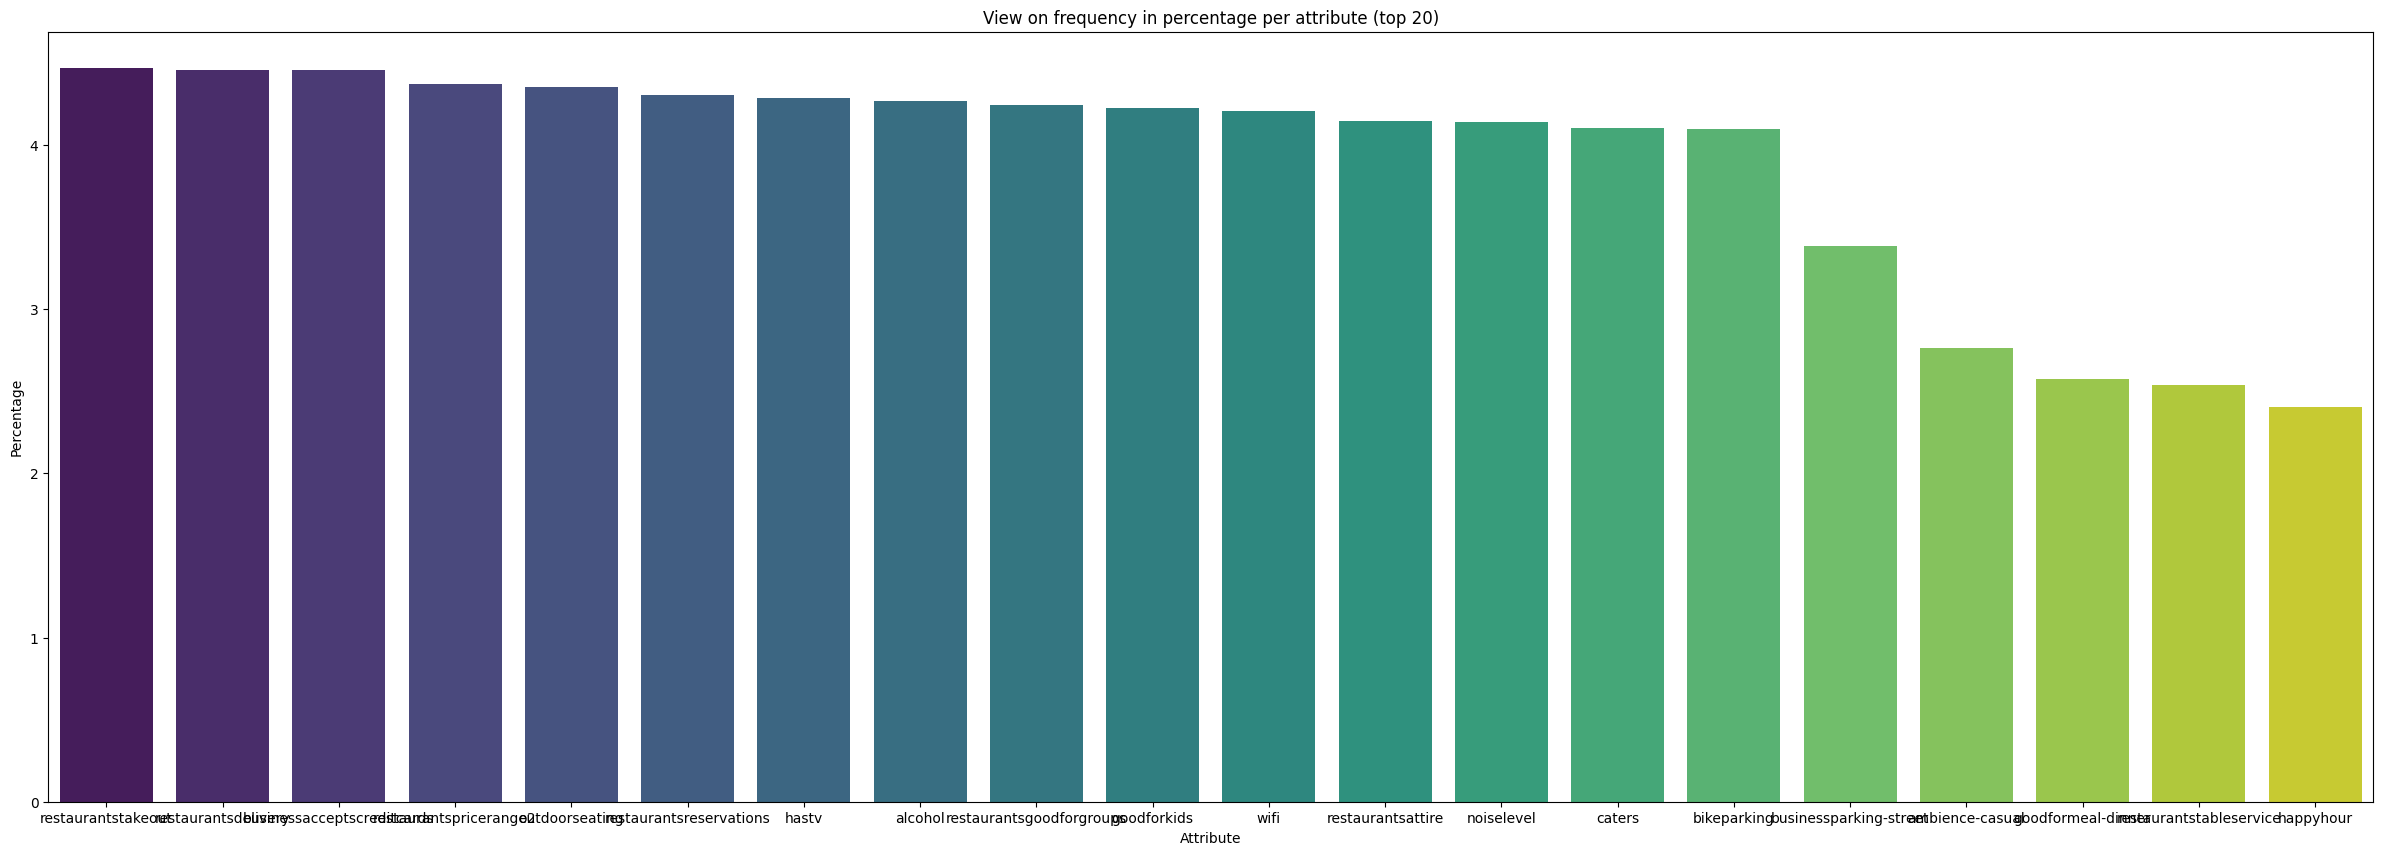

In [53]:
##################################################################
# Calculate the percentage distribution
attribute_counts = attribute_individ_df["attributes_list"].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot the results
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attributes", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View on frequency in percentage per attribute (top 20)")
sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Percentage")
plt.show()

/tmp/ipykernel_69510/3644161473.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


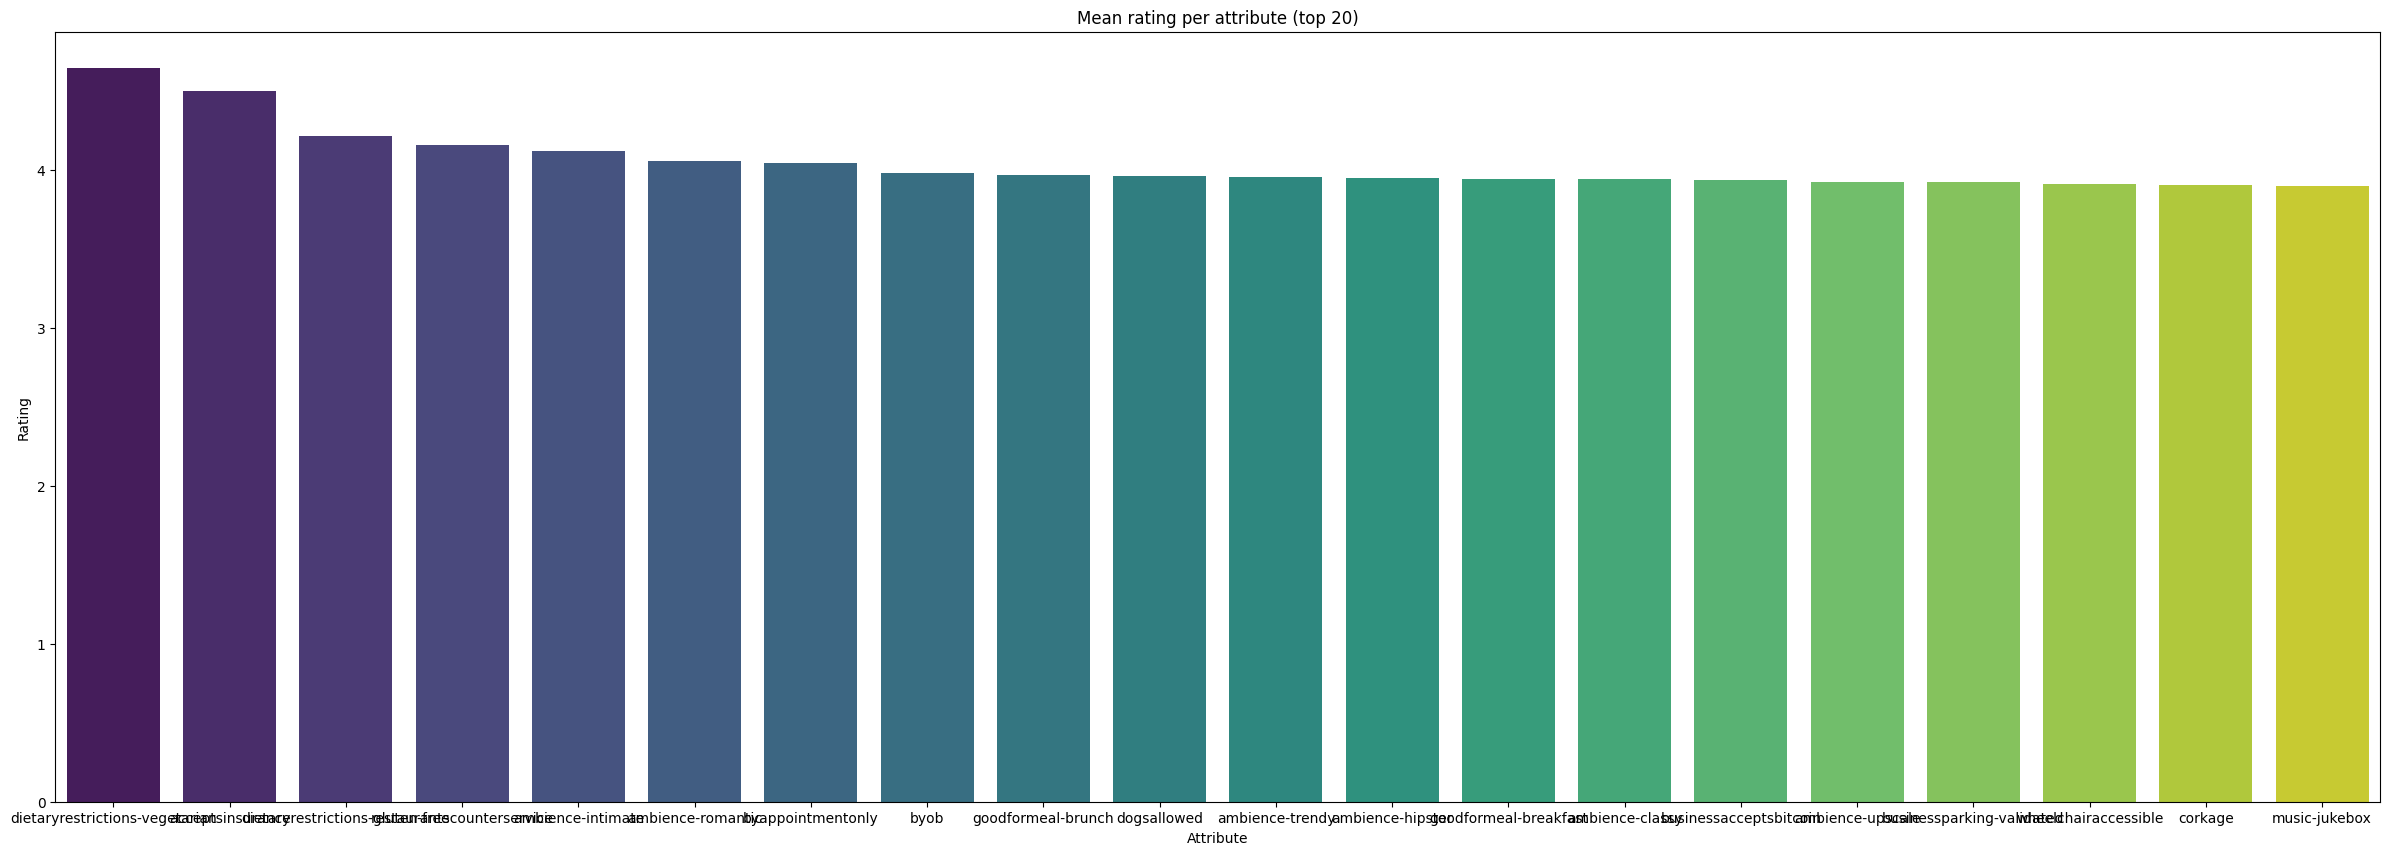

In [54]:
##################################################################
# AVERAING PER attribute

# Plot the results
mean_ratings = attribute_individ_df.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Rating")
plt.show()


#### Average rating per attribute for reviews judged "useful" at least 2 times

/tmp/ipykernel_69510/1833592862.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


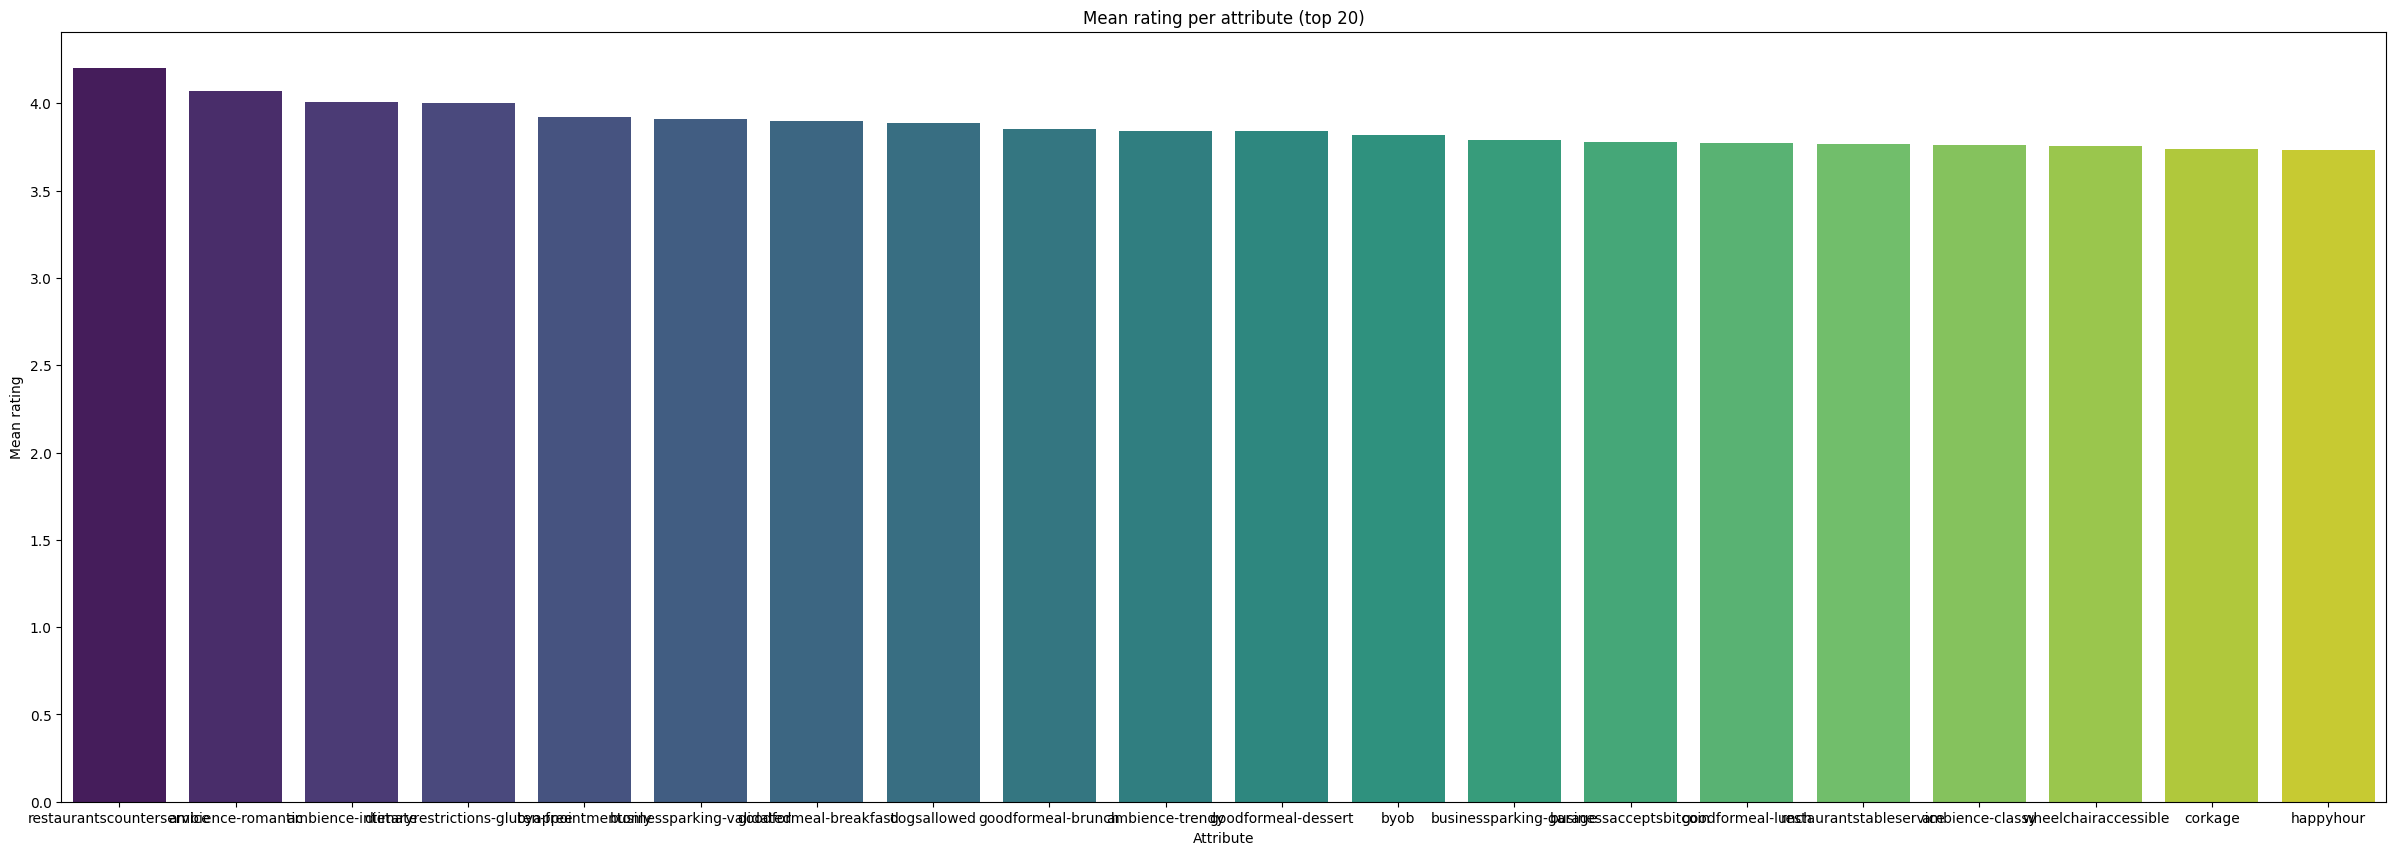

/tmp/ipykernel_69510/1833592862.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


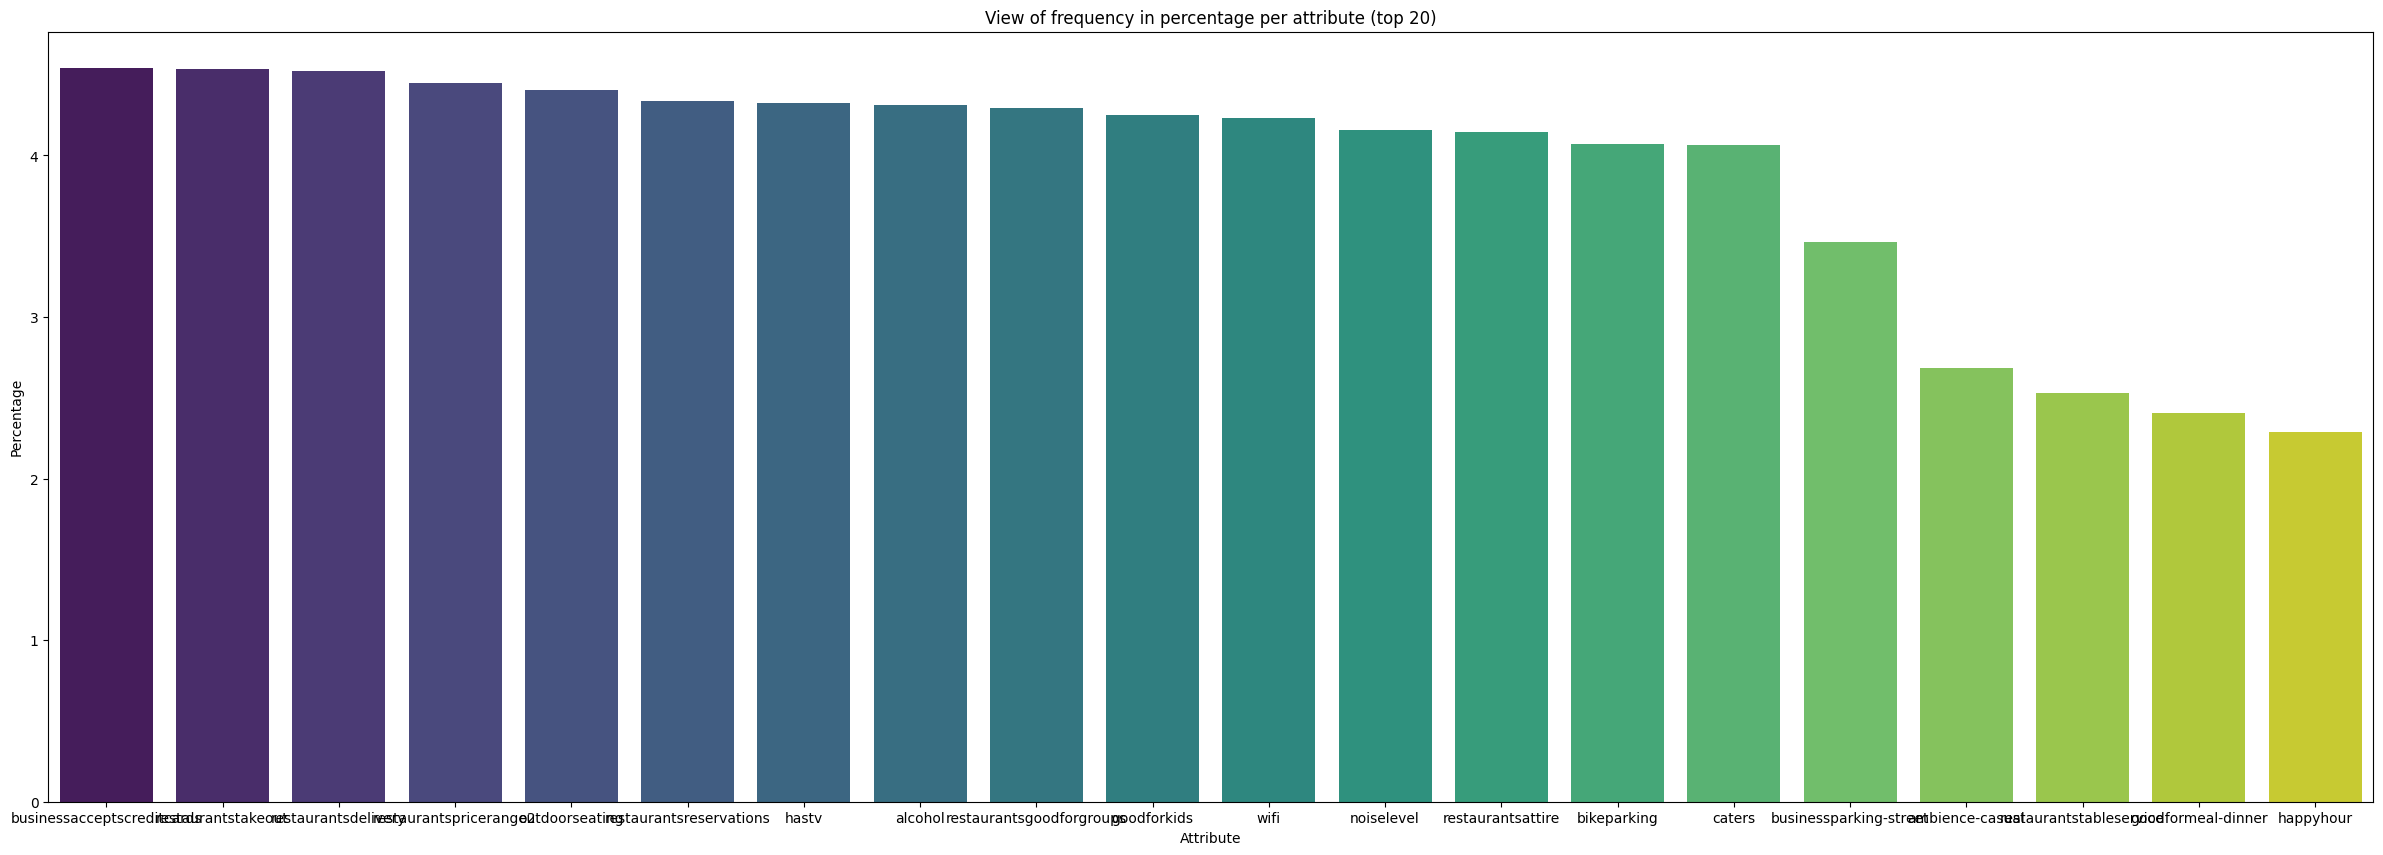

In [55]:
# Keep utility score >= 5
df_data_utility = attribute_individ_df[attribute_individ_df["useful"] >= 5]
attribute_counts = df_data_utility["attributes_list"].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot RATING
mean_ratings = df_data_utility.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Mean rating")
plt.show()


# Plot FREQUENCY
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attribute", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View of frequency in percentage per attribute (top 20)")
sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Percentage")
plt.show()

#### Plot Per Group Attribute

In [56]:
# Mean rating per category
mean_ratings["group_attribute"] = mean_ratings["attributes_list"].map(Attribute_groups)
mean_ratings = mean_ratings.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by=["group_attribute", "rating"], ascending=False)
mean_ratings.head(10)

,group_attribute,attributes_list,rating
63,service,restaurantscounterservice,4.200000
55,service,byappointmentonly,3.920097
58,service,dogsallowed,3.887083
56,service,byob,3.819209
52,service,businessacceptsbitcoin,3.778061
66,service,restaurantstableservice,3.768100
54,service,businessparking-valet,3.681564
67,service,wifi,3.662020
64,service,restaurantsdelivery,3.645666
65,service,restaurantsreservations,3.644993


/tmp/ipykernel_69510/4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


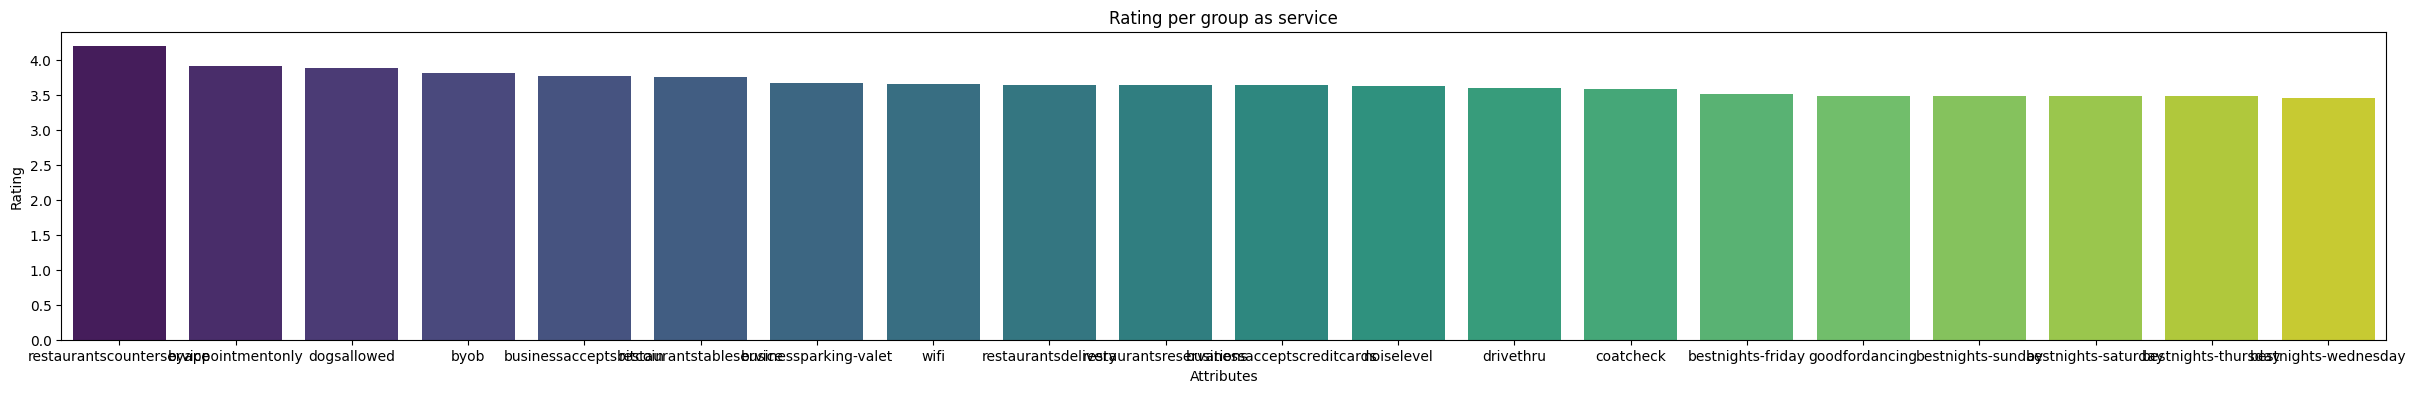

/tmp/ipykernel_69510/4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


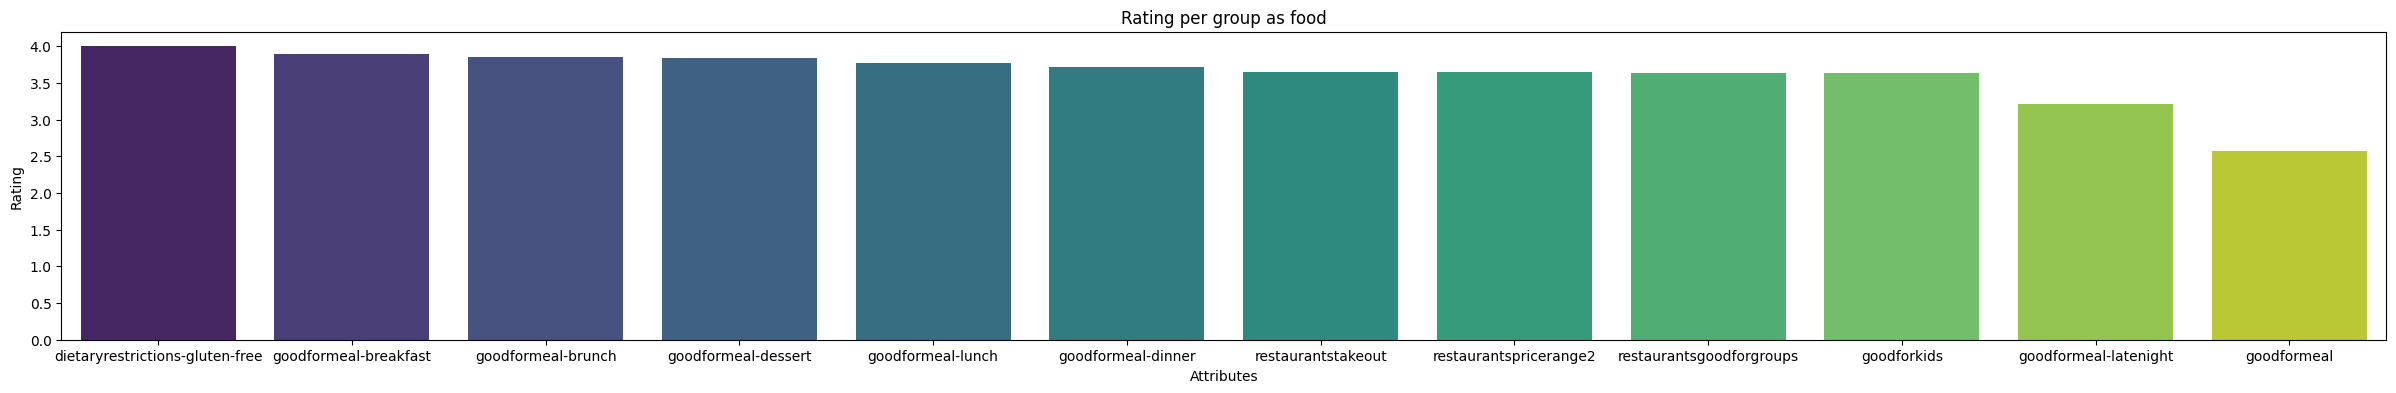

/tmp/ipykernel_69510/4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


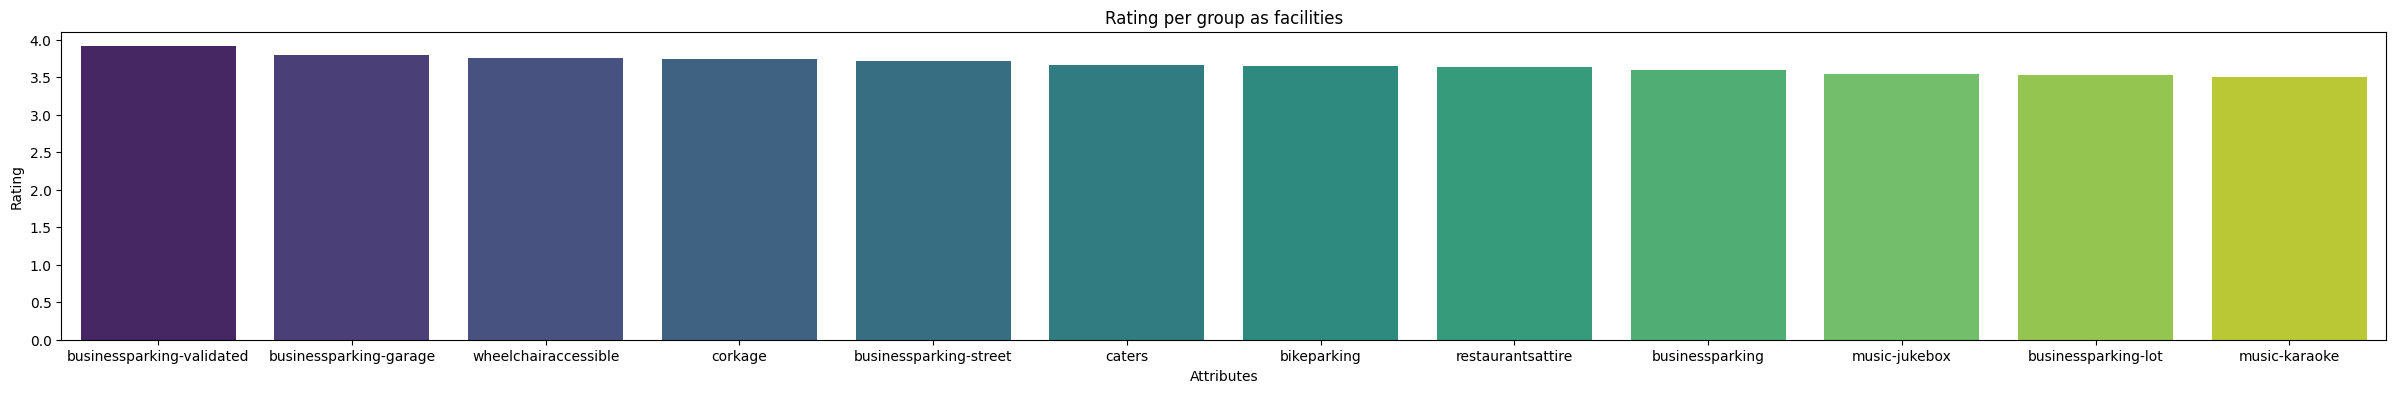

/tmp/ipykernel_69510/4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


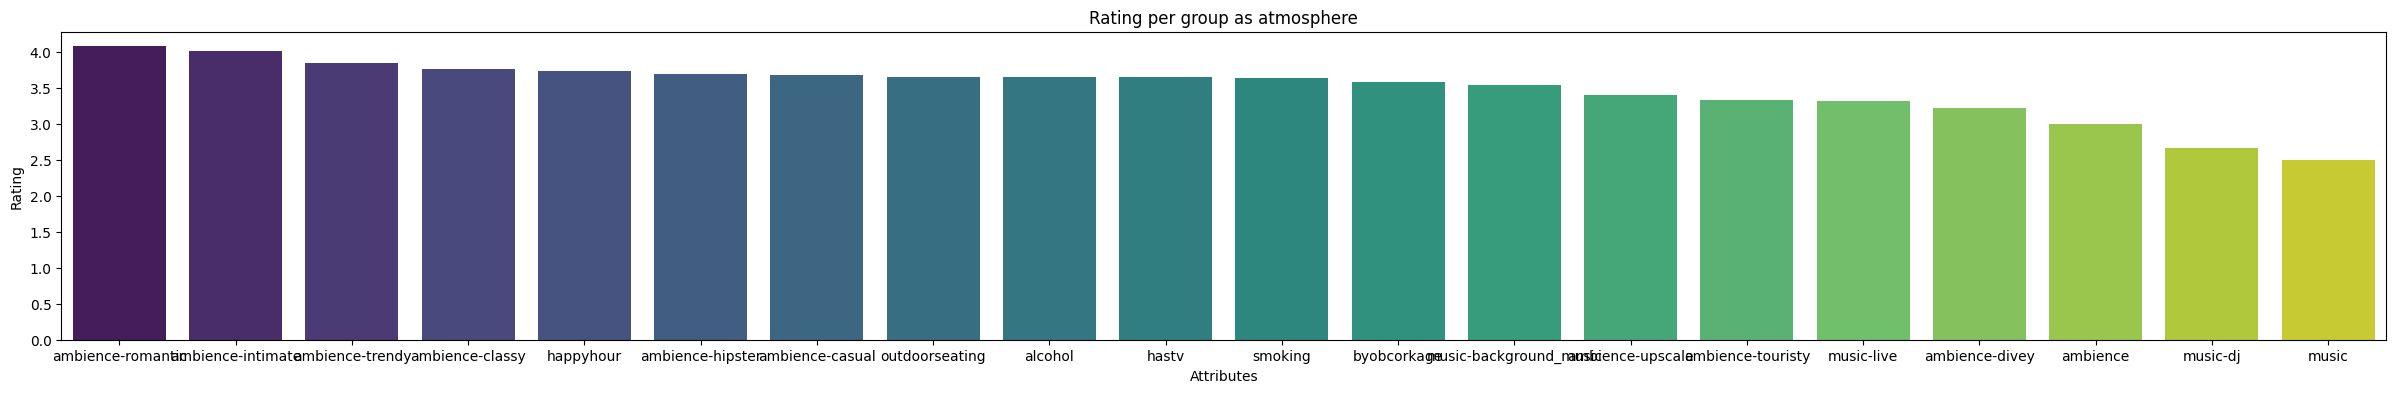

In [57]:
# Barplots per attribute
for group in mean_ratings["group_attribute"].unique():
    df_filt = mean_ratings[mean_ratings["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Rating per group as {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Rating")
    plt.show()

### 2. Analysis based on sentiments

In the following section we will compute a ranking based on a score obtained by considering the mean of a sentiment analysis of reviews. When a review is judged "POSITIVE" the reviews gets value 1, else 0. Then, an average per category or attribute respectively is computed. The factors are then ranked according to the score obtained. This method is used to consider the sentimental aspect of the review as said. In this way, we obtain a trace of the categories that tend to be associated globally with positive emotions.

#### Approach 1 -  Classic

The analysis is performed in the classical way described above.

In [60]:
# Compute a mean per category
categories_individ_df.drop(categories_individ_df[categories_individ_df['sentiment'] == "None"].index, inplace = True)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("NEGATIVE", 0)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("POSITIVE", 1)
mean_sent_category = categories_individ_df.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()

In [ ]:
# Heat map per postal code
cuisine_df = categories_individ_df[categories_individ_df["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("Category")
plt.show()

#### Approach 2 -  weights given by "useful" dimension.

We try then to see how items changes when assigning more weights to reviews according to the dimension "useful". We should have a better differenciation in the ratings. Therefore, it is as if we relied on the judgment of the crowd to give reviews a special treatment. This is done by simply replicating values according to the number in the column "useful". For example, if review n°1 has a value of 3 in "useful", we replicate it 3 times.

Let's analyse now the similarities of groups with the score based on sentiments and the groups with score based on ratings.

With respect to the group "ambiance", we find that reviews associated to restaurants with category items related to a dimension that is related to music openess, social gathering and relaxation are ranked first. We find for example categories such as karaoke, art, social, spas in the top values...

With respect to the group "cuisine type" which refers to food, it seems that this method does not highlight any pattern.

With respect to the group "establishment" it seems that categories caffes are privilegied.

In [ ]:
# Extend dataframe by replicating obbservation according to "useful" value
df_useful_category = categories_individ_df.loc[np.repeat(categories_individ_df.index, categories_individ_df["useful"])].reset_index()

# Compute a mean per category
mean_sent_category = df_useful_category.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)


# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()

We note that this approach brings the score closer to 0.5, so we tend to find homogeneous results as for ratings.

In [61]:
# Heat map per postal code
cuisine_df = df_useful_category[df_useful_category["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

#### Approach 2 - Focus on attributes

We replicate the experience, but for attributes and replicating the same treatment on useful reviews.

In [ ]:
# Compute a mean sentiment per attribute
attribute_individ_df.drop(attribute_individ_df[attribute_individ_df['sentiment'] == "None"].index, inplace = True)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("NEGATIVE", 0)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)

df_useful_attribute = attribute_individ_df.loc[np.repeat(attribute_individ_df.index, attribute_individ_df["useful"])].reset_index()

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per category and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attribute")
    plt.ylabel("Sentiment")
    plt.show()

In order to extract the maximum amount of information from our data set, we wanted to take advantage of the "useful" variable. Thus, our hypothesis is that a person who gives a "useful" vote finds the respective review relevant. It means that either the person has not visited the restaurant yet and she has learned something useful, or she has visited it and she share the opinion in the review. As such, it is a quality metric that we would like to use to hilight insights.

In the analysis above, we sought to explore insights in the datasets targeted at Philadelphia using NLP methods and statistical calculations. Our approach is based on a quantitative and qualitative view of reviews linked to "attributes" and "categories" by business. This gives us an appreciative idea of the importance of different ratings. As the problem seeks to discover what is liked by consumers, we refined our analysis to consider only reviews classified as positive. We continued by groupping the categories and attributes by factors (groups) to get a more precise view of similar variables in our analysis. 

#### Approach 3 - Keeping reviews given by more qualitative people

As scores seem to be homogene, we need to go deeper in the exploration by considering customer quality this time. Having fans useful reviews is a factor of credibility as well. We will filter the reviews to keep only those provided by people having provided by ustomers having a profile with at least 1 useful review and at least 1 fan. This filter reduces the total number of reviews of almost 50%. It is not an issue as the sample remain big enough. We migh have a better view on distinguishing quality. 

In [62]:
# # Filter the df dataset based on quality of users
df_users = pd.read_csv("data/ATML2024_users.csv", header=0)
df_users = df_users[["user_id", "useful", "fans"]]
df_users = df_users[(df_users["useful"] >= 1) & (df_users["fans"] >= 1)]
df_UserQuality_atr = attribute_individ_df[attribute_individ_df["user_id"].isin(df_users["user_id"].unique())]
df_UserQuality_cat = categories_individ_df[categories_individ_df["user_id"].isin(df_users["user_id"].unique())]

In [ ]:
##################################################################
# Compute a mean sentiment score per category
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_UserQuality_cat = df_UserQuality_cat.loc[np.repeat(df_UserQuality_cat.index, df_UserQuality_cat["useful"])].reset_index()

mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()


##################################################################
# Compute a mean sentiment per attribute
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_useful_attribute = df_UserQuality_atr.loc[np.repeat(df_UserQuality_atr.index, df_UserQuality_atr["useful"])].reset_index()

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per attribute and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Sentiment score")
    plt.show()

In [ ]:
# Heat map per postal code
cuisine_df = df_UserQuality_cat[df_UserQuality_cat["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

Having compared the results of this method with those of previous ones, we notice that the results are rather similar. Even though we have lost a lot of reviews, we note that preferences remain the same.

In [ ]:
# Compute a mean rating score per category
mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["rating"].mean().reset_index()
mean_sent_category.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(20, 4))
    plt.title(f"Mean sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment score")
    plt.show()


# Compute a mean rating per attribute
mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_sent_attribute.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Mean sentiment score per group {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attribute")
    plt.ylabel("Sentiment")
    plt.show()

The results are rather similar to the barplots for attributes seen earlier.
In the group facilities: having wheelchair accessibleand corkage are appreciated.
In the group food: good for meal, reservations and take out, are liked.
In the group service: Dogs allowed and bitcoin acceptance are liked.

## 2.1.3 Conclusion on insights


Generally speaking, we can interpret negativity as frustration and unfulfilled needs. As a result, there\"s a chance to be successful in the restaurant business by satisfying unfulfilled needs, and consequently to do good business. To maximize chances of success, one need to target what most consumers are saying by voting

 Here are our pieces of advice:
1) Their focus should not be on what is appreciated, but on avoiding replicating what is not. That seems be more important.,
We see from our findings that consumers appreciate all restaurants in general, with the exception of those that are cheap (in terms of quality) or that don't stand out from the crowd (traditional American cuisine). The focus should therefore be on avoiding those items at the bottom of the rankings. An overall comparison of the heat maps shows that low scores are given to foods that tend to be cheap. These tend to be traditional American cuisine, fast food, pizza and buffets for example.

2) To be successful, they need to assess their risk profile and play strategically with zip codes and set up shop where there's high demand and little supply. This requires additional analysis and domain knowledge.


## 2.1.4  Aspect Based Sentiment Analysis

In this section we perform a so-called Aspect-Based Sentiment Analysis.
The idea is to give a sentiment to a review based on a list of predifined aspect. For example in the sentence : 

<br> "The food was great in a clean place. However the service was terrible." <br>

We would like to extract a positive sentiment for food and a negative sentiment for service.
Aspects are manually selected. We choose to expose the results using the aspects : "food" and "service".

Extensive list of words related to another word or theme can be find in NLP libraires such as nltk. For the sake of simplicity we use a predefined list.<br>
We also lemmatize all the reviews. This is done in the `lemmatize_string` from our util functions. It is based on nltk librairy. 


In [ ]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)

(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


In [ ]:
# Predefined aspects and their related keywords
aspects_keywords = {
    "food": ["food", "dish", "meal", "taste", "flavor"],
    "service": ["service", "staff", "waiter", "waitress"],
    "price":["cost","fee","rate","price","fare","value","expense","cheap","expensive"]
}
# Lemmatize 
for key, item in aspects_keywords.items():
    aspects_keywords[key] = [lemmatize_string(it) for it in item]

In [ ]:
# We also lematize all the reviews This might run for a while 
# df_data_res['text_lem'] = df_data_res['text'].apply(lemmatize_string)

First we split the review in n reviews (n being the number of aspects. For example food and service). Notice some parts of the reviews can overlap. It is not a problem. <br>
This is done with the util function `extract_aspect_sentences(review, aspects_keywords)`. It first divides the review in sentences. This is simalar to tokenization, but where the tokens are sentences. The word of the sentence are lemnatized. Finally, for each of those sentences, if one of the aspect keyword appears, the sentence is extracted and appended to a sub-review of that aspect. This is done for all the aspects giving us a dictionary of aspect :: sub-review.

In [ ]:
# Example of use 
review = "The food was great in a clean place. However the service was terrible."
aspect_sentences = extract_aspect_sentences(review, aspects_keywords)
print(aspect_sentences)

{'food': ['The food was great in a clean place.'], 'service': ['However the service was terrible.'], 'price': []}


We use a pretrained model blob from TextBlob librairy (similar to nltk) to pereform sentiment analysis. This is done on each of the sub-reviews linked to an aspect. <br> `analyze_aspect` combines aspect extraction as above and sentiment classification per aspect. The sentiment analysis per aspect is done with pretrained `blob` model from `TextBlob` librairy. Better sentiment analysis could be obtained using transformers at the cost of expensive computational power requirement. 

In [ ]:
# Example of use 
reviews = ["The food was great in a clean place. However the service was terrible.",
           "Nice food. Clean place. Good price."]
aspect_sentiments = [analyze_aspects(review, aspects_keywords) for review in reviews]
for it, r in enumerate(reviews):
    print('\'{}\' \n {}'.format(r, aspect_sentiments[it]))
    print('')

'The food was great in a clean place. However the service was terrible.' 
 {'food': 'positive', 'service': 'negative', 'price': 'neutral'}

'Nice food. Clean place. Good price.' 
 {'food': 'positive', 'service': 'neutral', 'price': 'positive'}



The piece of code below is performing the aspect-based sentiment analysis on each all the reviews and and create a column for each of the aspect the sentiment analysis applies. 

In [ ]:
score = {}
for key in aspects_keywords:
    score[key] = []

# Iterate all reviews in ['text'] column of the DataFrame
for index, row in df_data_res.iterrows():
    aspect_score = analyze_aspects(row['text'], aspects_keywords)
    for key in aspects_keywords:
        score[key].append(aspect_score[key])

# Append to the right of the dataframe
df_aspect_score = pd.DataFrame(score)
if not bool([ii for ii in list(aspects_keywords.keys()) if ii in df_data_res.columns]):
    df_data_res = pd.merge(df_data_res, df_aspect_score, left_index=True, right_index=True)

Below the ratio of positive to negative sentiment and positive to all sentiments is computed.

In [ ]:
sentiment_count = {}
sentiment_ratio  = {}
sentiment_ratio_all = {}
for key in score:
    sentiment_count[key] = Counter(score[key])
    sentiment_count[key] = dict(sorted(sentiment_count[key].items()))
    sentiment_ratio[key] = sentiment_count[key]['positive'] / ( sentiment_count[key]['positive'] + \
                                                               sentiment_count[key]['negative'])
    sentiment_ratio_all[key] = sentiment_count[key]['positive'] / \
                             ( sentiment_count[key]['positive'] + sentiment_count[key]['negative'] + \
                               sentiment_count[key]['neutral'] )

print('Sentiment Ratio = {}'.format(sentiment_ratio))

Sentiment Ratio = {'food': 0.8062085593731163, 'service': 0.8189185237786921, 'price': 0.7645313410692524}


The aspect `price` gets a lower score. <br>
Plot the sentiment count 

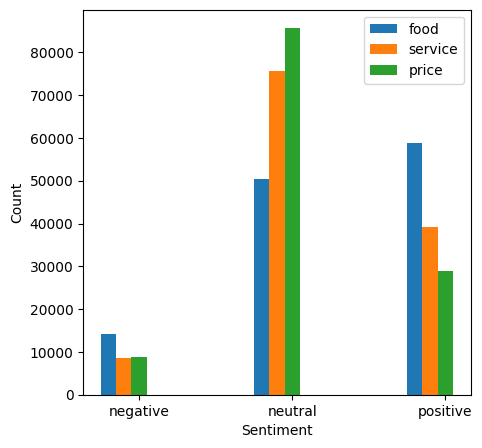

In [ ]:
plt.figure(figsize=(5,5))
shift = 0
for key in score:
    names  = list(sentiment_count[key].keys())
    values = list(sentiment_count[key].values())
    plt.bar(np.arange(len(sentiment_count[key]))+shift, values, tick_label=names, width=0.1, label=key)
    shift += 0.1
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.legend(loc='best')
plt.show()

More than half of the reviews are without sentiment. We identify the following possible reasons : 
- The review is not refering to the aspect. It is possible that the people talk less frequently of the price than the food or service. 
- The way aspects are extracted is basic. It is explicitely looking if lemmatized word qualifying some aspect appears in the lemmatized review. It could be that the review talks about an aspect without using any of the predifined words.

One can also look at the ratio of positive to negatif sentiments 

To summerize this part, one can see that in general the reviews with extracted aspects are positive. Reviewers seem to be more critic towards the price than the food or the service. 

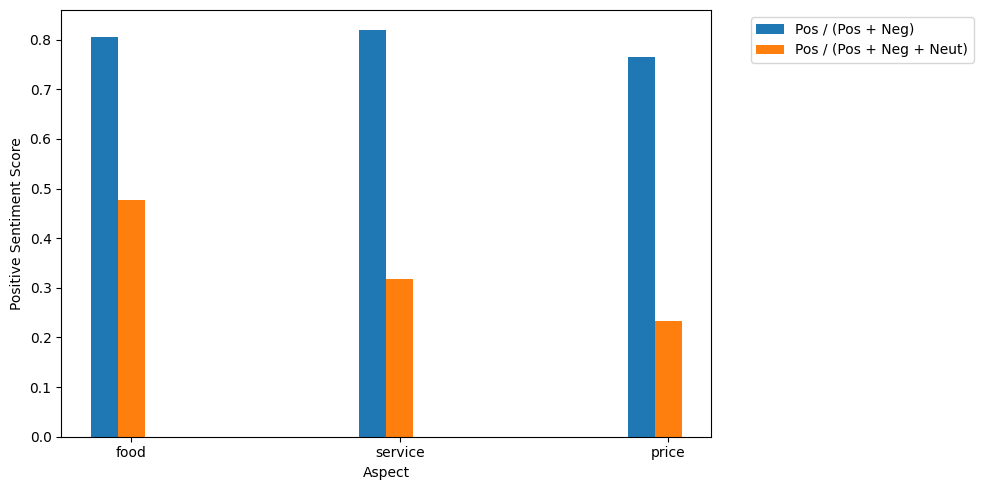

In [ ]:
plt.figure(figsize=(10,5))

aspect = list(sentiment_ratio.keys())

plt.bar(np.arange(len(aspect)), list(sentiment_ratio.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg)')
plt.bar(np.arange(len(aspect))+0.1, list(sentiment_ratio_all.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg + Neut)')
plt.xlabel('Aspect')
plt.ylabel('Positive Sentiment Score')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

## 2.2 Food Trends Over Time

We can analyse the food trends by two steps:

1 -  We have the category information of the restaurants and their rating. We can distribute these ratings among the categories and take an average per category. This approach gives us a generic liking of the certain categories. However, it doesn't show the trend. We also count the number of time a category appeared in the dataset. This shows the interest of the people to the certain style of restaurants. Using the average rating and the frequency we identify the most trendy restaurant categories. 

2 - Some categories such as `food`, `restaurant` are quite common where as some categories are rather rare such as `american (traditional)` or `burger`. To identify the importance we calculate **rating-frequency ratio** (`rating_freq_ratio`) which gives number percentage of the restaurants-rating a category exists. We apply 5% filter on this value to discard the categories that are rare in the restaurant business.

3 - From there we can identify the food trends. Most of the categories are related with the food style. We select the most trending 10 food style. We then calculate their corresponding rating by time and draw the evolution of the ratings by time


In [ ]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)


(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


In [ ]:
data_cat_ratings =  df_data_res[['id','date','categories_list', 'rating']]
data_cat_rating_single = data_cat_ratings.explode('categories_list')
data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_ratings)
data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) #.set_index('date')

data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]
# data_cat.hist()

data_cat.sort_values(by='mean_rating', ascending=False, inplace=True)
data_cat.head(20)


,categories,frequency,mean_rating,rating_freq_ratio
176519,specialty food,7207,4.072430,0.058397
176363,cafes,7019,4.055706,0.056874
176005,vegetarian,6366,4.024505,0.051582
176160,desserts,6404,4.011555,0.051890
175591,beer,6226,4.008834,0.050448
175591,wine & spirits,6226,4.008834,0.050448
176522,coffee & tea,11148,3.974435,0.090330
175692,japanese,6805,3.907127,0.055140
176522,food,37842,3.888642,0.306626
174802,asian fusion,6733,3.877469,0.054556


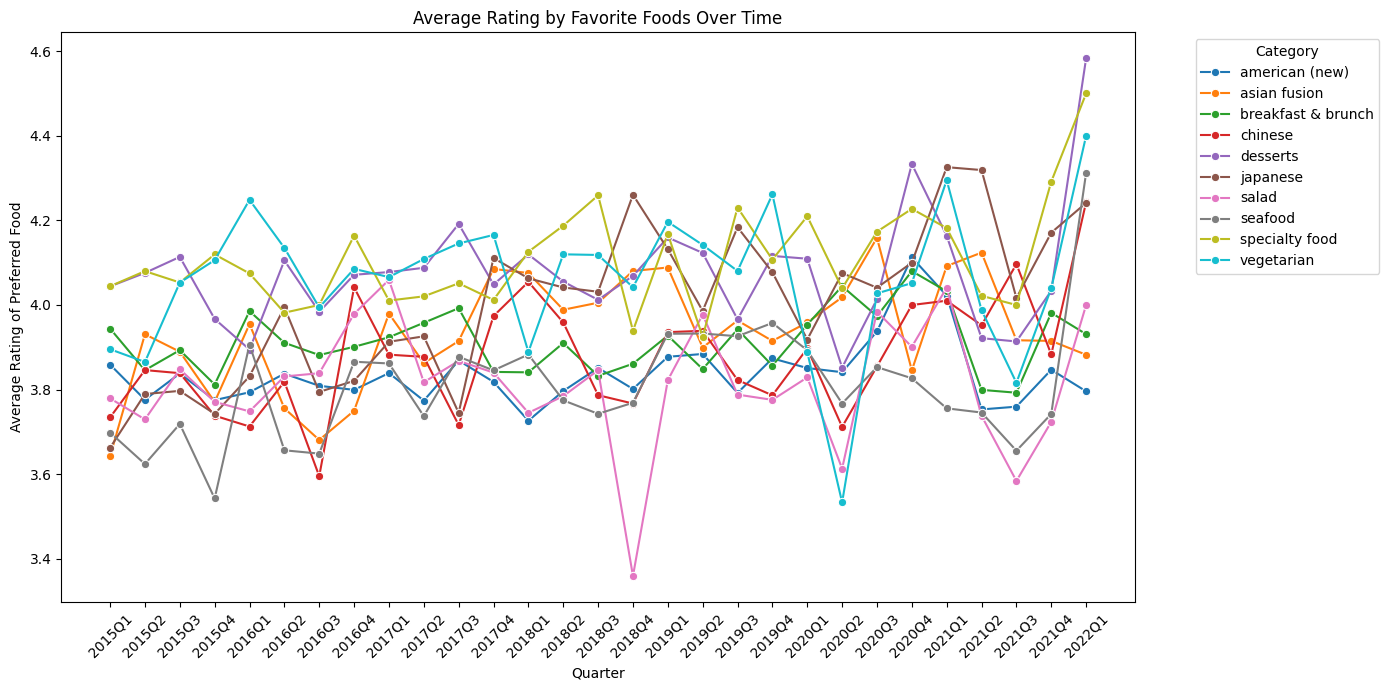

In [ ]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).rating.mean().reset_index()

df_pivot = df_grouped.pivot(index='quarter', columns='categories', values='rating')
df_pivot = df_pivot.sort_index()

plot_trending_figures(df_grouped,  x='quarter', y='rating', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Average Rating of Preferred Food',
                    title='Average Rating by Favorite Foods Over Time')


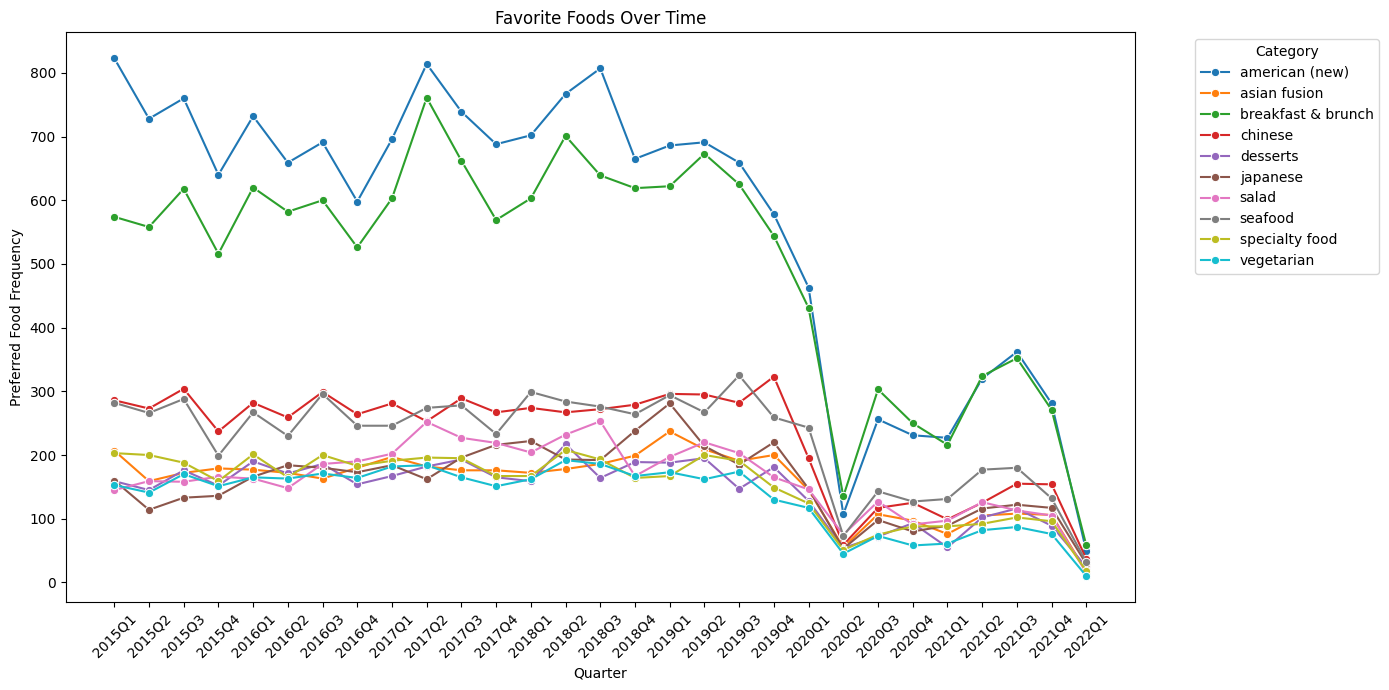

In [ ]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).size().reset_index(name='frequency')



plot_trending_figures(df_grouped,  x='quarter', y='frequency', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Preferred Food Frequency', 
                    title='Favorite Foods Over Time')


## 2.3 Suggestions for the restaurants

We can apply the similar method to the attributes of the restaurants. We can find the most appreciated attributes and see their combined effect on the rating. We also cut the attributes that present less than 5% of the restaurants. They're indeed very rare ones. Although such attributes yield high average ratings they may not reflect the values reality accurately.

Unlike categories attribues seem to distribute more uniformly. Average rating per attribute is found 3.8 and average presence of the atributes are found 50%. Many attributes are very common such as `RestaurantsTakeOut` or `RestaurantsDelivery` which exist 98% of the restaurants in our dataset. Similar to categories, some attributes are rare. We apply the same `rating_freq_ratio` 5% limit to the attributes.

To focus on rarer yet valuable attributes we develop a strategy to assign weights to importance of the presence of an attribute, its ratio and and its mean rating. We selected the attributes which present less than 90% and more than 10% of the restaurants. In addition, we selected the attributes which have more than 3.75 average rating. We concluded these values visually by looking at their respective distribution. Finally, we assigned 0.5 weight on the mean rating and 0.25 weight on frequency and rating_frequency ratio, normalize the values with MinMax scale and calculated a composite score. The importance of the attributes could be seen in the heat map below.


In [ ]:
data_att_ratings =  df_data_res[['id','date','attributes_list', 'rating']] 
data_att_rating_single = data_att_ratings.explode('attributes_list')
data_att_rating_single['mean_rating'] = data_att_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_att_rating_single['frequency'] = data_att_rating_single['attributes_list'].map(data_att_rating_single['attributes_list'].value_counts())
data_att_rating_single['rating_freq_ratio'] = data_att_rating_single['frequency']/len(data_att_ratings)
data_att = data_att_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}) #.set_index('date')

data_att = data_att[(data_att['rating_freq_ratio'] > 0.05) ]
data_att.sort_values(by='mean_rating', ascending=False, inplace=True)
data_att.head(5)
# data_att_generic = data_att[data_att.mean_rating > 3.8].sort_values(by='rating_freq_ratio', ascending=False)
# data_att_generic = data_att[(data_att.mean_rating > 3.8) & (data_att.rating_freq_ratio < 0.9)].sort_values(by='rating_freq_ratio', ascending=False)

,attributes,frequency,mean_rating,rating_freq_ratio
175989,ByAppointmentOnly,20975.0,4.029273,0.169956
176422,BYOB,18047.0,3.962653,0.146231
176363,GoodForMeal-brunch,14885.0,3.953846,0.120610
176420,DogsAllowed,58831.0,3.952797,0.476696
176420,Ambience-trendy,17443.0,3.941352,0.141337


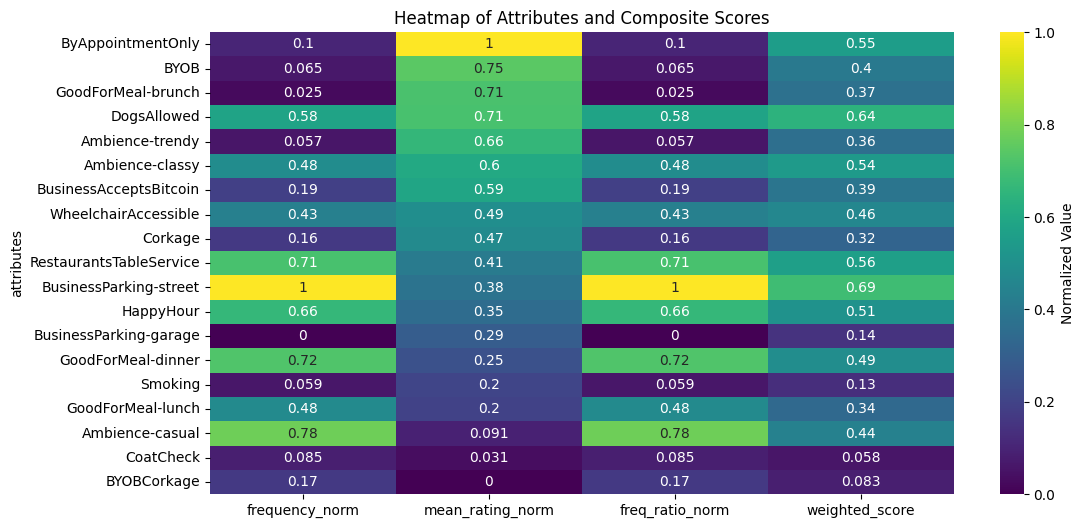

In [ ]:
df = data_att[(data_att.mean_rating >= 3.75) & (data_att.rating_freq_ratio < 0.9) & (data_att.rating_freq_ratio > 0.10)].sort_values(by='mean_rating', ascending=False)

# Normalize the metrics
scaler = MinMaxScaler()
df[['frequency_norm', 'mean_rating_norm', 'freq_ratio_norm']] = scaler.fit_transform(df[['frequency', 'mean_rating', 'rating_freq_ratio']])

# Calculate a weighted score (example weights: frequency=0.3, mean_rating=0.5, freq_ratio=0.2)
weights = {'frequency': 0.25, 'mean_rating': 0.5, 'rating_freq_ratio': 0.25}
df['weighted_score'] = (weights['frequency'] * df['frequency_norm'] +
                        weights['mean_rating'] * df['mean_rating_norm'] +
                        weights['rating_freq_ratio'] * df['freq_ratio_norm'])

# Prepare data for heatmap
heatmap_data = df[['attributes', 'frequency_norm', 'mean_rating_norm', 'freq_ratio_norm', 'weighted_score']].set_index('attributes')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Normalized Value'})
plt.title('Heatmap of Attributes and Composite Scores')
plt.show()


Along with the generic attributes like `BikeParking`, `CreditCardAcceptance` etc, we recommend a new restaurant to be chic ad elite category. According to our findings, restaurants having following attributes have higher rating potential.
- By Appointment Only
- Business Parking (street is enough)
- Classy and Casual Ambiance
- Table Service
- Dinner meal specialized 
- Happy hour
- Dog friendly